In [59]:
import os 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.spatial.distance import pdist
import itertools as it 
os.chdir('..')
from src.data_cleaning import *
from src.autograd_mds import *
from autograd import grad, elementwise_grad, jacobian
from loguru import logger
import sys

from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state
from sklearn.manifold import MDS
# Unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import warnings


In [2]:
os.listdir()


['.git',
 '.gitignore',
 'config',
 'data',
 'doc',
 'Dockerfile',
 'notebook',
 'pyproject.toml',
 'README.md',
 'requirements.txt',
 'src',
 'test']

In [3]:
url = 'http://cs.bc.edu/~prudhome/AAPLD/animal-similarity.csv'

raw_dataset = pd.read_csv(url, index_col=0)
list_of_animal_pairs = raw_dataset.index.str.split('~')

In [4]:
dissimilarity_weights = [np.exp(-1*x) for x in raw_dataset['Average_Rating']]


In [5]:
weighted_list_of_animal_pairs = [x+ [dissimilarity_weights[_]] for _, x in enumerate(list_of_animal_pairs)]

In [6]:
animal_pair_data = pd.DataFrame.from_records(list_of_animal_pairs, columns=['first_animal', 'second_animal'], index= raw_dataset.index)

In [7]:
animal_pair_data.sort_values(by = ['first_animal', 'second_animal'], inplace=True)

In [8]:
unique_animals = set(animal_pair_data.first_animal).union(animal_pair_data.second_animal)

In [9]:
animal_pairs = nx.Graph()
animal_pairs.add_nodes_from(unique_animals)
animal_pairs.add_weighted_edges_from(weighted_list_of_animal_pairs)

In [10]:
low_degree=[k for k,v in animal_pairs.degree._nodes.items() if len(v) < 32]

In [11]:
animal_pairs.remove_nodes_from(low_degree)

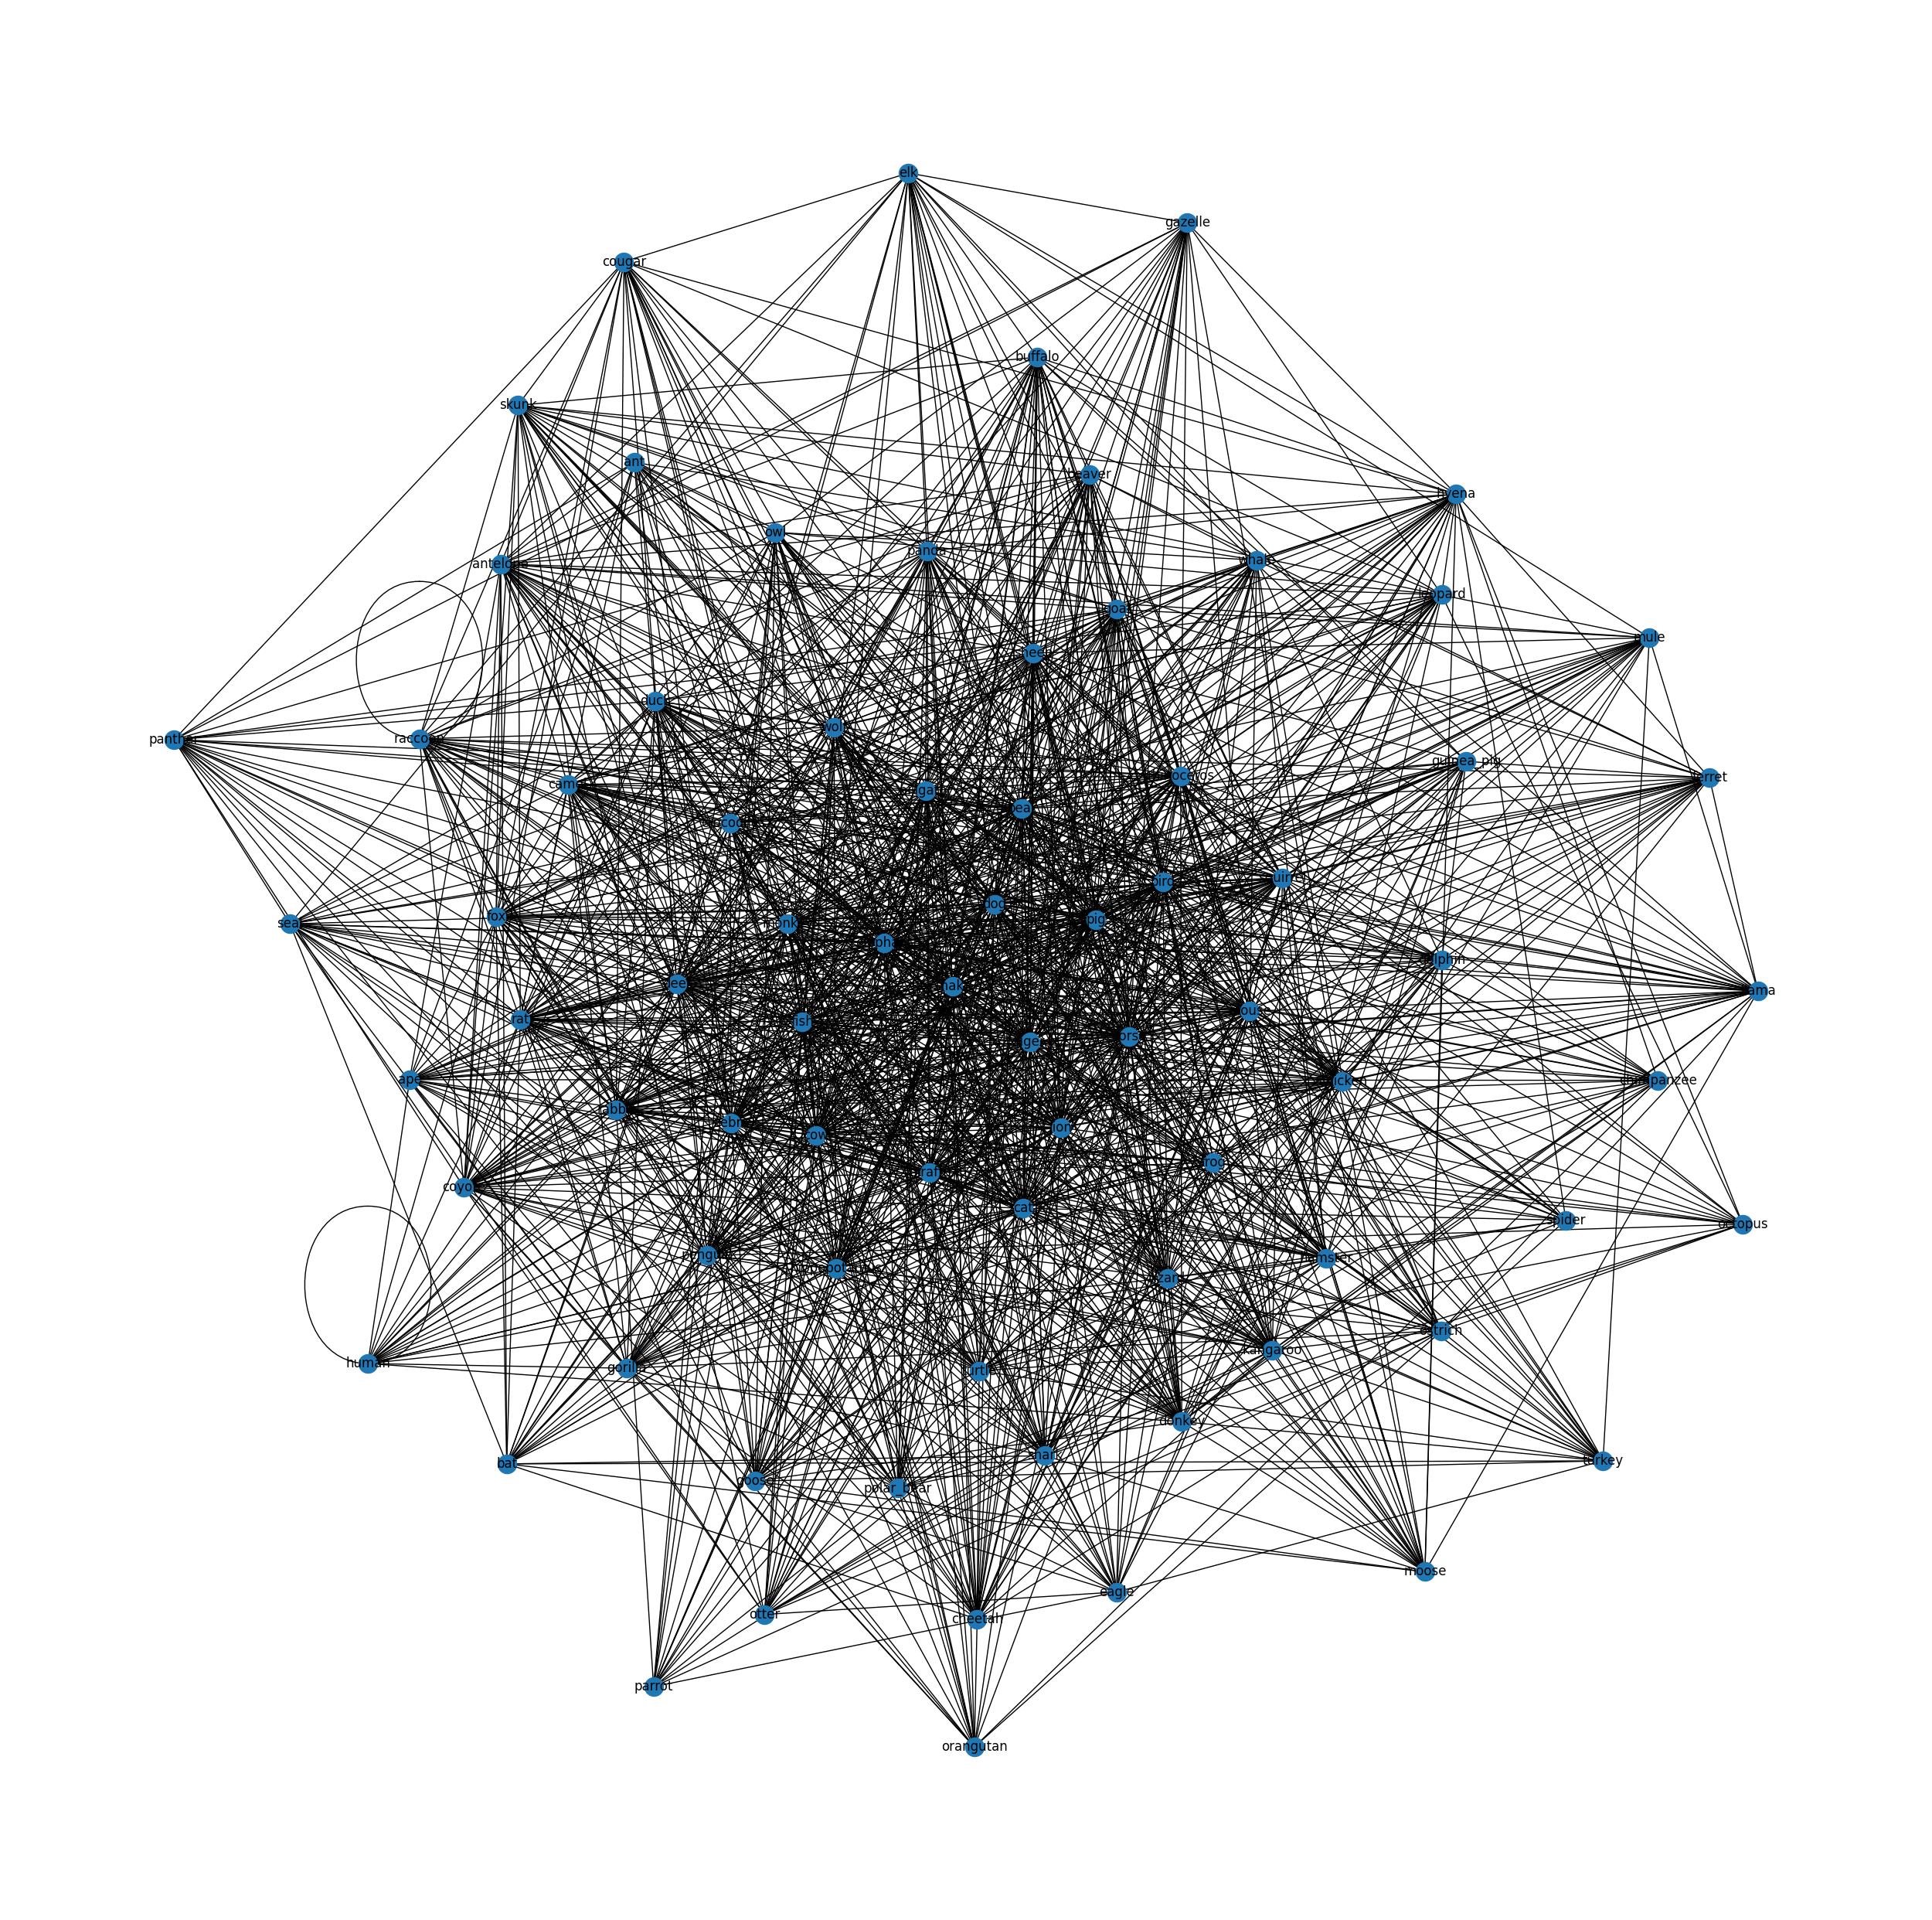

In [12]:
fig, ax = plt.subplots(figsize=(32,32))
nx.draw(animal_pairs, with_labels=True, ax=ax)

plt.show()

In [13]:
connected_list = [x for x in animal_pairs.nodes]

In [14]:
# try the small list, or, failing that, just the apes

In [15]:
smaller_animal_pair_data=animal_pair_data.loc[animal_pair_data['first_animal' ].isin( connected_list) & animal_pair_data['second_animal' ].isin( connected_list) ] 

In [16]:
joined_data=smaller_animal_pair_data.join(raw_dataset).drop(columns='[All_Ratings]')

In [17]:
big_matrix = pd.DataFrame(index=connected_list, columns = connected_list)

In [18]:
joined_data

first_animal second_animal  Average_Rating
Pair                                                         
alligator~antelope    alligator      antelope           1.940
alligator~bird        alligator          bird           2.080
alligator~buffalo     alligator       buffalo           1.080
alligator~elephant    alligator      elephant           1.140
alligator~fish        alligator          fish           1.000
...                         ...           ...             ...
zebra~seal                zebra          seal           1.040
zebra~shark               zebra         shark           1.067
zebra~snake               zebra         snake           1.880
zebra~tiger               zebra         tiger           2.720
zebra~turtle              zebra        turtle           1.120

[1601 rows x 3 columns]

In [19]:
#TODO wrap below section into functions

In [20]:
for row in joined_data.iterrows():
    big_matrix.loc[row[1].first_animal][row[1].second_animal] = row[1].Average_Rating
    big_matrix.loc[row[1].second_animal][row[1].first_animal] = row[1].Average_Rating

In [21]:
big_matrix = big_matrix.astype(float)

In [22]:
# big_matrix = big_matrix[big_matrix.isna().mean(1) < 0.5]
# big_matrix = big_matrix[big_matrix.index.to_list()]

In [23]:
big_matrix = big_matrix[big_matrix.isna().mean(1) < 0.33]

In [24]:
big_matrix = big_matrix[big_matrix.index.to_list()]

In [25]:
plt.matshow(big_matrix)

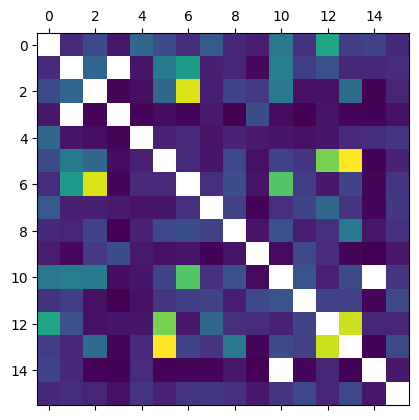

In [26]:
plt.show()

In [27]:
big_matrix.isna().mean(1)

dog         0.0625
cow         0.1250
zebra       0.0625
fish        0.1250
monkey      0.0625
tiger       0.0625
horse       0.0625
pig         0.0625
giraffe     0.0625
snake       0.0625
deer        0.1250
bear        0.0625
cat         0.0625
lion        0.0625
bird        0.1250
elephant    0.0625
dtype: float64

In [28]:
big_matrix.shape

(16, 16)

In [29]:
big_matrix

dog    cow  zebra   fish  monkey  tiger  horse    pig  giraffe  \
dog         NaN  1.620  2.175  1.340    2.72  2.200  1.660  2.480    1.600   
cow       1.620    NaN  2.700    NaN    1.29  3.117  3.860  1.460    1.540   
zebra     2.175  2.700    NaN  1.080    1.20  2.720  5.917  1.460    2.040   
fish      1.340    NaN  1.080    NaN    1.10  1.180  1.100  1.370    1.020   
monkey    2.720  1.290  1.200  1.100     NaN  1.480  1.640  1.280    1.500   
tiger     2.200  3.117  2.720  1.180    1.48    NaN  1.620  1.320    2.125   
horse     1.660  3.860  5.917  1.100    1.64  1.620    NaN  1.720    2.250   
pig       2.480  1.460  1.460  1.370    1.28  1.320  1.720    NaN    2.020   
giraffe   1.600  1.540  2.040  1.020    1.50  2.125  2.250  2.020      NaN   
snake     1.420  1.110  1.880  2.260    1.38  1.240  1.300  1.060    1.300   
deer      3.060  3.220  3.180  1.180    1.32  2.040  4.820  1.700    2.300   
bear      1.760  1.960  1.240  1.000    1.24  1.780  1.960  2.080    1.425   
cat       4.080  2.300  1.260  1.300    1.32  5.160  1.360  2.717    1.700   
lion      1.940  1.560  2.840  1.067    1.64  6.220  2.040  1.780    3.100   
bird      2.050  1.580  1.060  1.060    1.68  1.060  1.080  1.100    1.340   
elephant  1.600  1.683  1.550  1.240    1.81  1.500  1.800  1.840    1.740   

          snake  deer   bear    cat   lion  bird  elephant  
dog        1.42  3.06  1.760  4.080  1.940  2.05     1.600  
cow        1.11  3.22  1.960  2.300  1.560  1.58     1.683  
zebra      1.88  3.18  1.240  1.260  2.840  1.06     1.550  
fish       2.26  1.18  1.000  1.300  1.067  1.06     1.240  
monkey     1.38  1.32  1.240  1.320  1.640  1.68     1.810  
tiger      1.24  2.04  1.780  5.160  6.220  1.06     1.500  
horse      1.30  4.82  1.960  1.360  2.040  1.08     1.800  
pig        1.06  1.70  2.080  2.717  1.780  1.10     1.840  
giraffe    1.30  2.30  1.425  1.700  3.100  1.34     1.740  
snake       NaN  1.16  2.160  1.660  1.100  1.00     1.360  
deer       1.16   NaN  2.360  1.480  2.200   NaN     1.800  
bear       2.16  2.36    NaN  2.080  2.020  1.10     2.160  
cat        1.66  1.48  2.080    NaN  5.820  1.56     1.560  
lion       1.10  2.20  2.020  5.820    NaN  1.04     2.160  
bird       1.00   NaN  1.100  1.560  1.040   NaN     1.340  
elephant   1.36  1.80  2.160  1.560  2.160  1.34       NaN

In [30]:
# todo make into function
similarities = big_matrix.to_numpy()
similarity_vec = np.tril(similarities, -1)
similarity_vec = similarity_vec[np.nonzero(similarity_vec)]

In [31]:
# FIll in NA's 

In [32]:
similarity_vec = np.nan_to_num(similarity_vec, nan=min(similarity_vec))

In [33]:
dissimilarity_vec = np.exp(-1*similarity_vec)
dissimilarity_vec/=np.linalg.norm(dissimilarity_vec)

In [34]:
len(dissimilarity_vec) 
# :=Y  = n(n-1)/2
# 2Y = n^2 - n
# 0 = n^2 - n - 2Y

# 0 = (n - 1/2) ^2 - 1/4 - 2Y 
# 2Y + 1/4 = (n - 1/2)^2
# N = 1/2 + sqrt(2Y + 1/4)


120

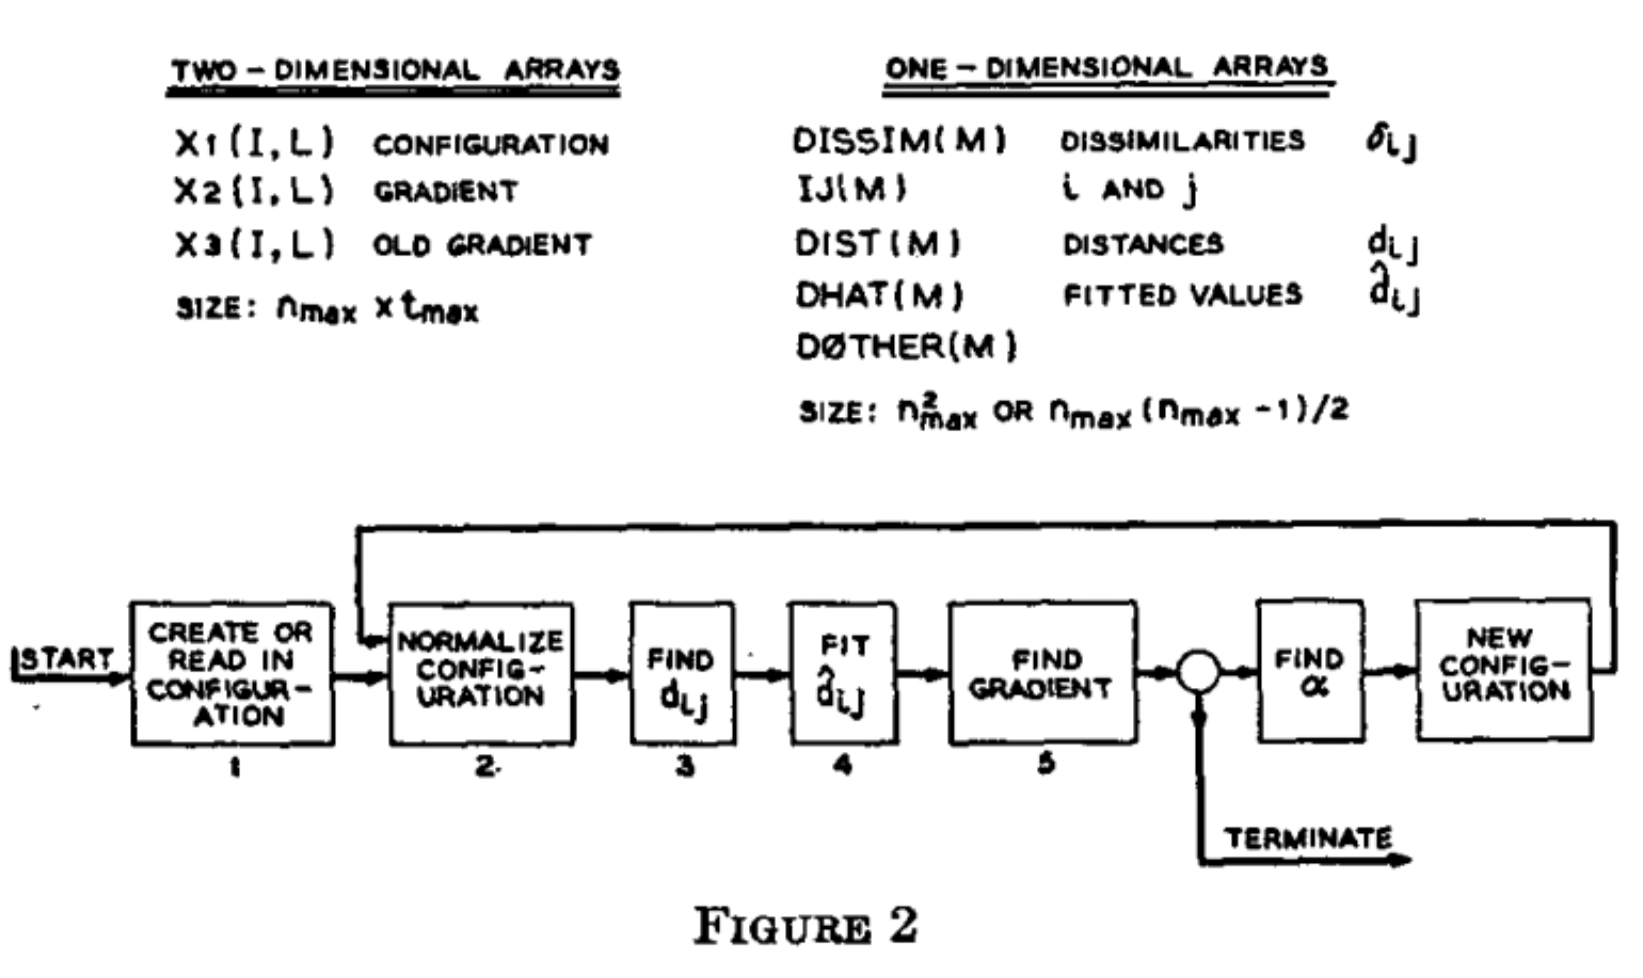
From Kruskal, 1964

Idea is to follow these steps, 

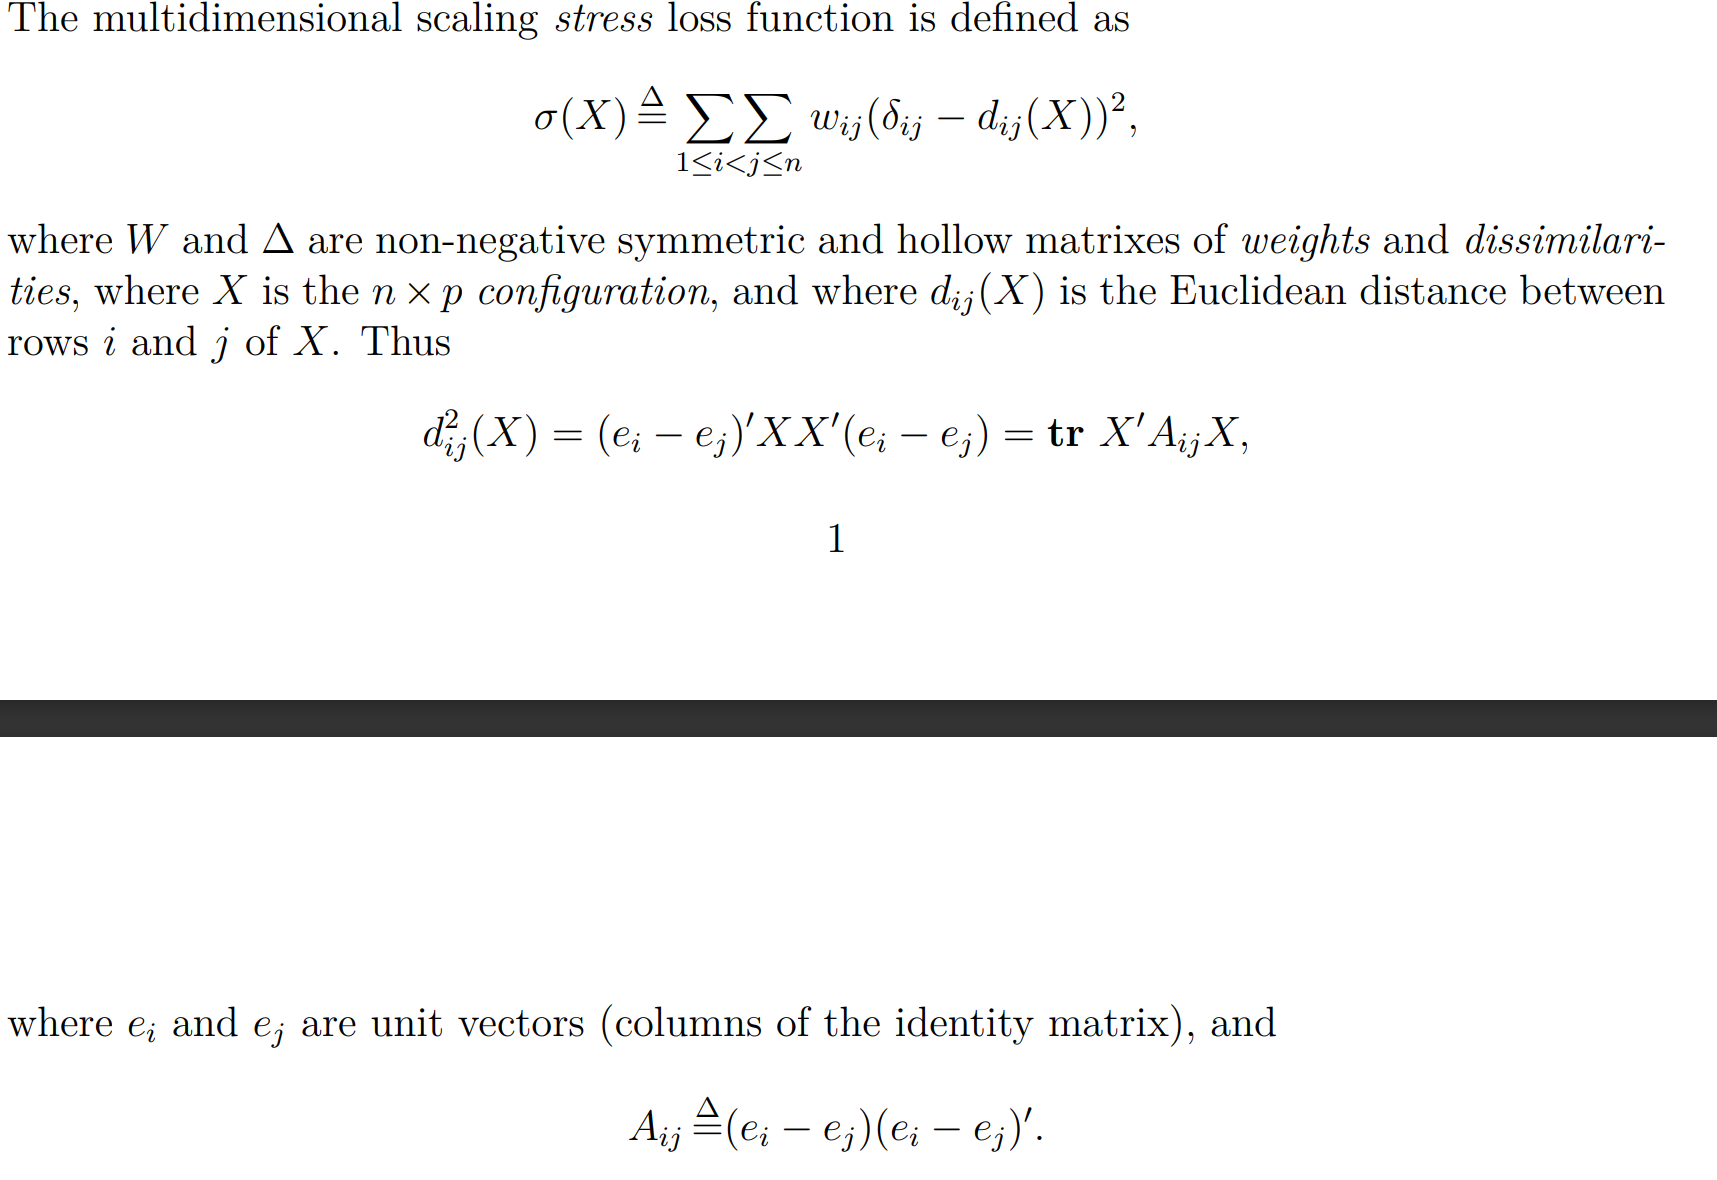
From https://jansweb.netlify.app/publication/deleeuw-e-18-c/
NB: $\delta_{ij}$ here is the true dissimilarity between $i$ and $j$ 

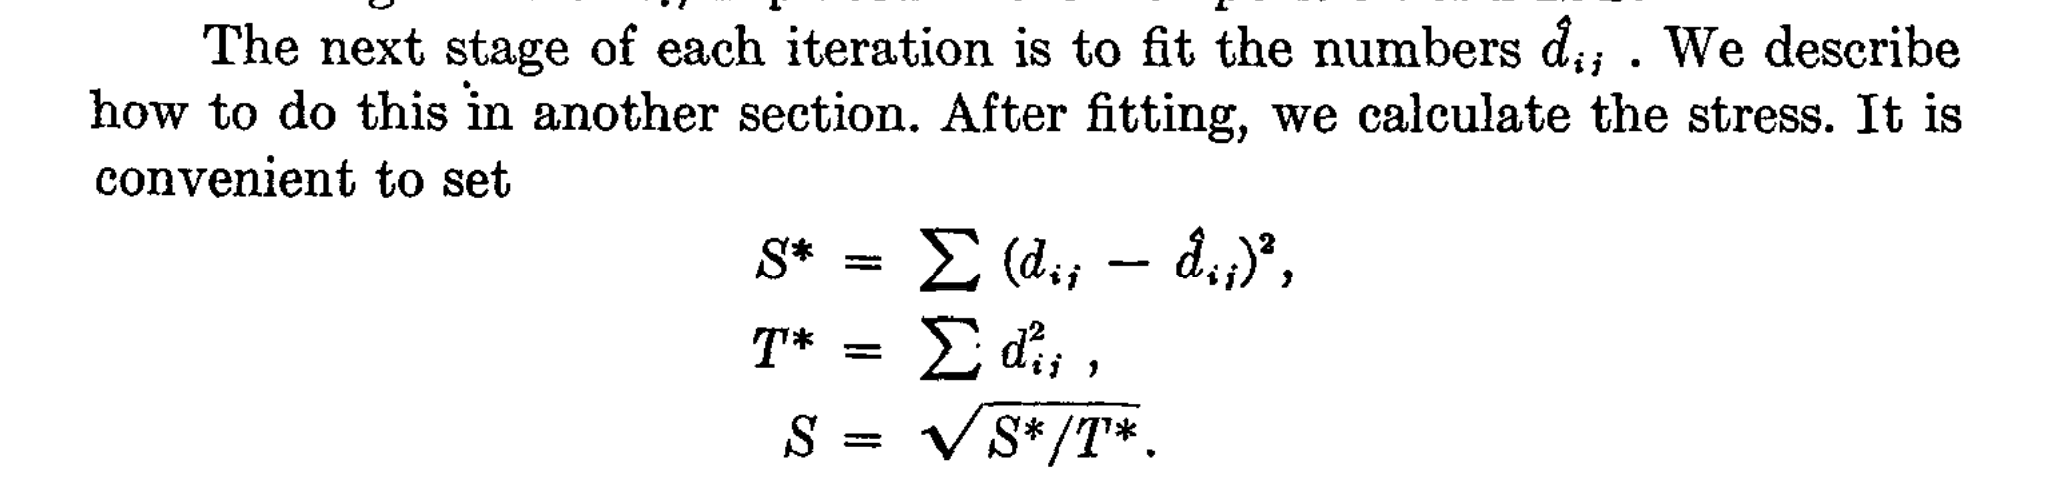
Stress Loss function from Kruskal, 1964

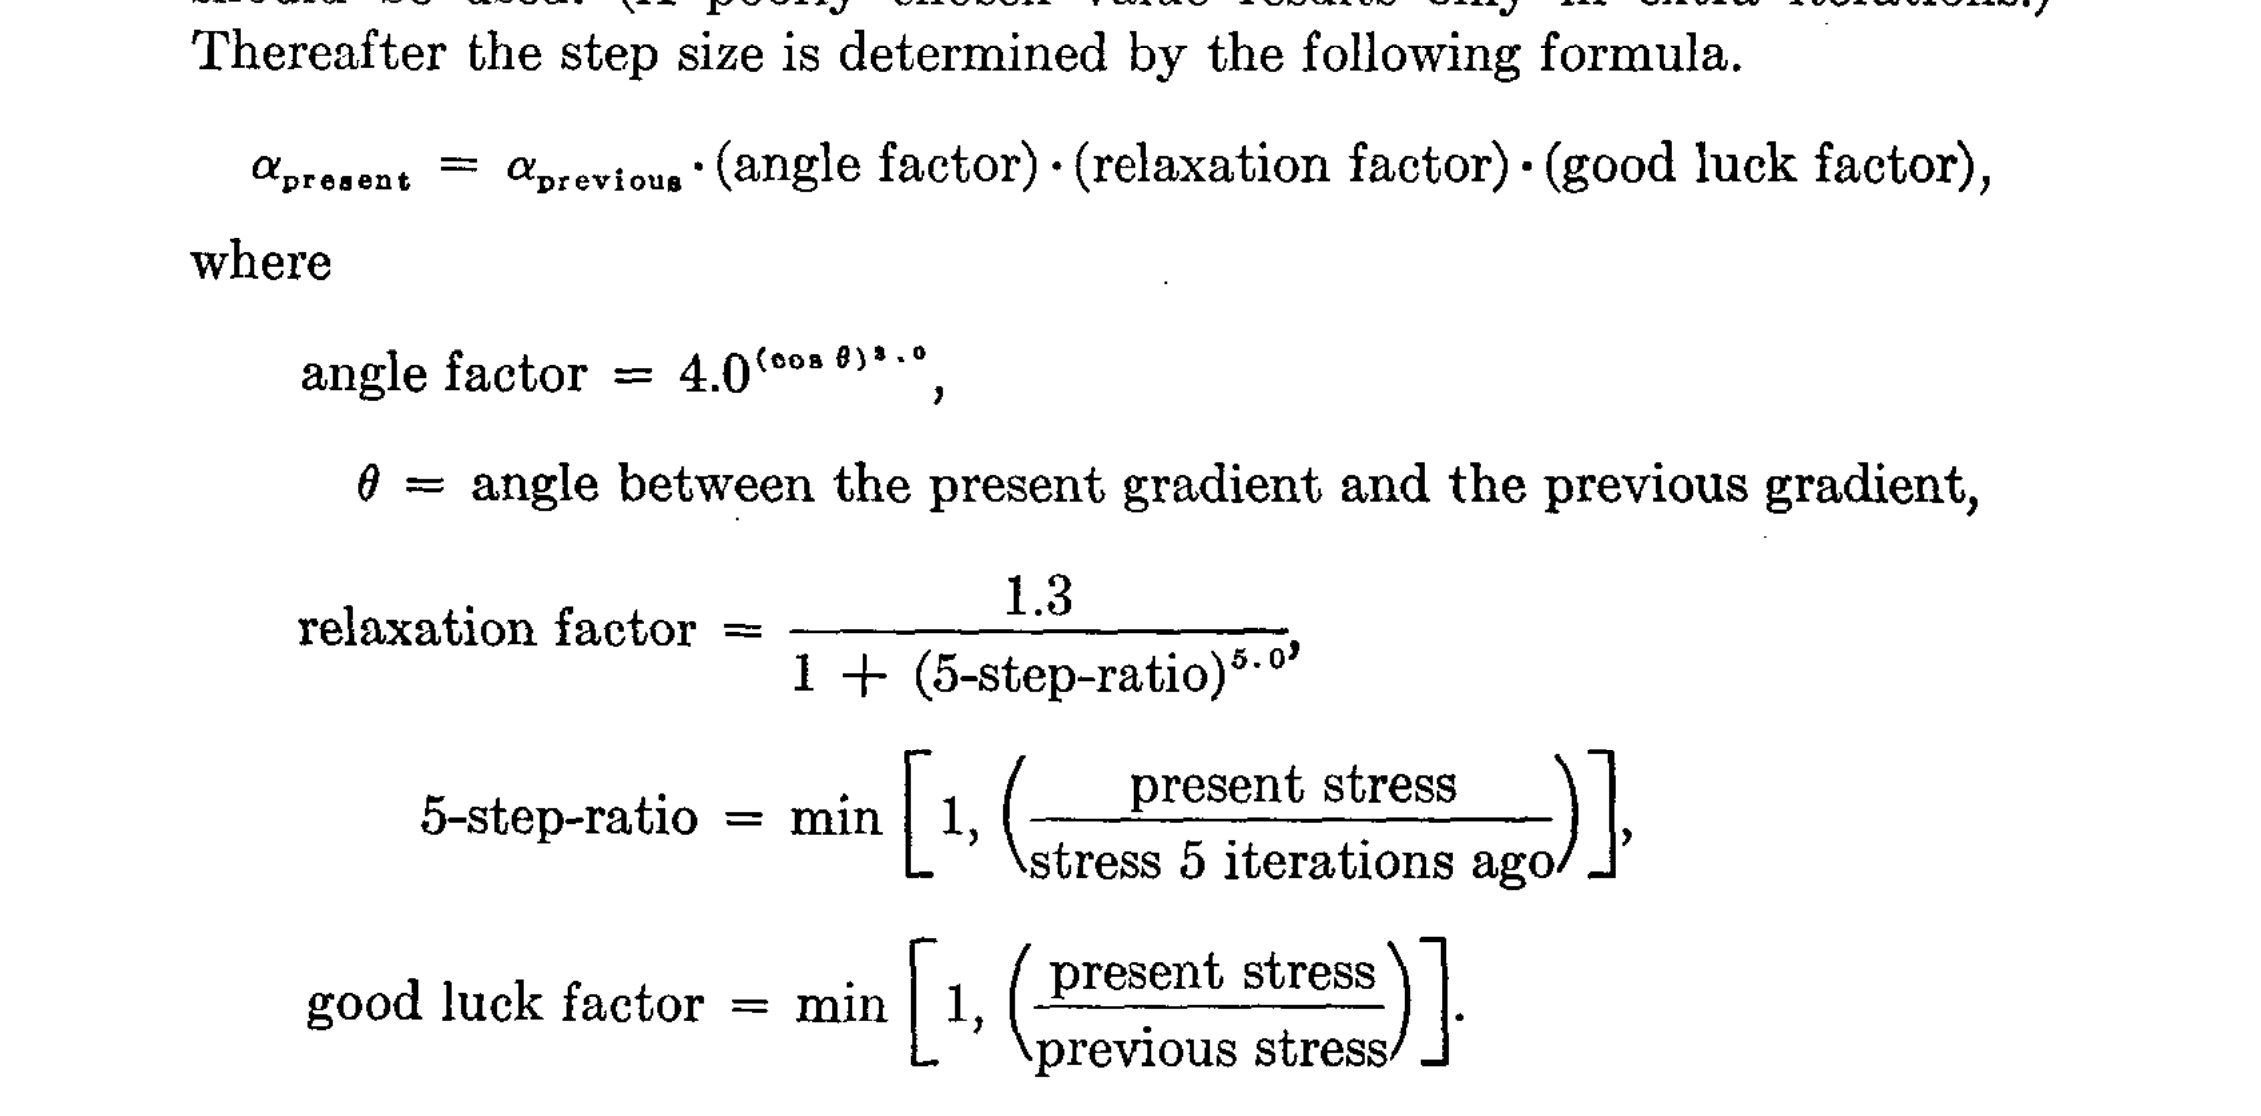
Optimizer from Kruskal, 1964

2022-09-01 04:24:00.325 | INFO     | src.autograd_mds:stress:53 - Sstar: 0.5073816225495709
2022-09-01 04:24:00.329 | INFO     | src.autograd_mds:stress:55 - Tstar: 1.0000000000000002
2022-09-01 04:24:00.336 | INFO     | src.autograd_mds:my_mds_training_loop:217 - Starting Stress: 0.7123072529109687
2022-09-01 04:24:00.400 | INFO     | src.autograd_mds:stress:53 - Sstar: Autograd ArrayBox with value 0.5073816225495709
2022-09-01 04:24:00.404 | INFO     | src.autograd_mds:stress:55 - Tstar: 1.0000000000000002
2022-09-01 04:24:00.454 | INFO     | src.autograd_mds:my_mds_training_loop:220 - Starting Gradient magnitude: 0.709729883168064


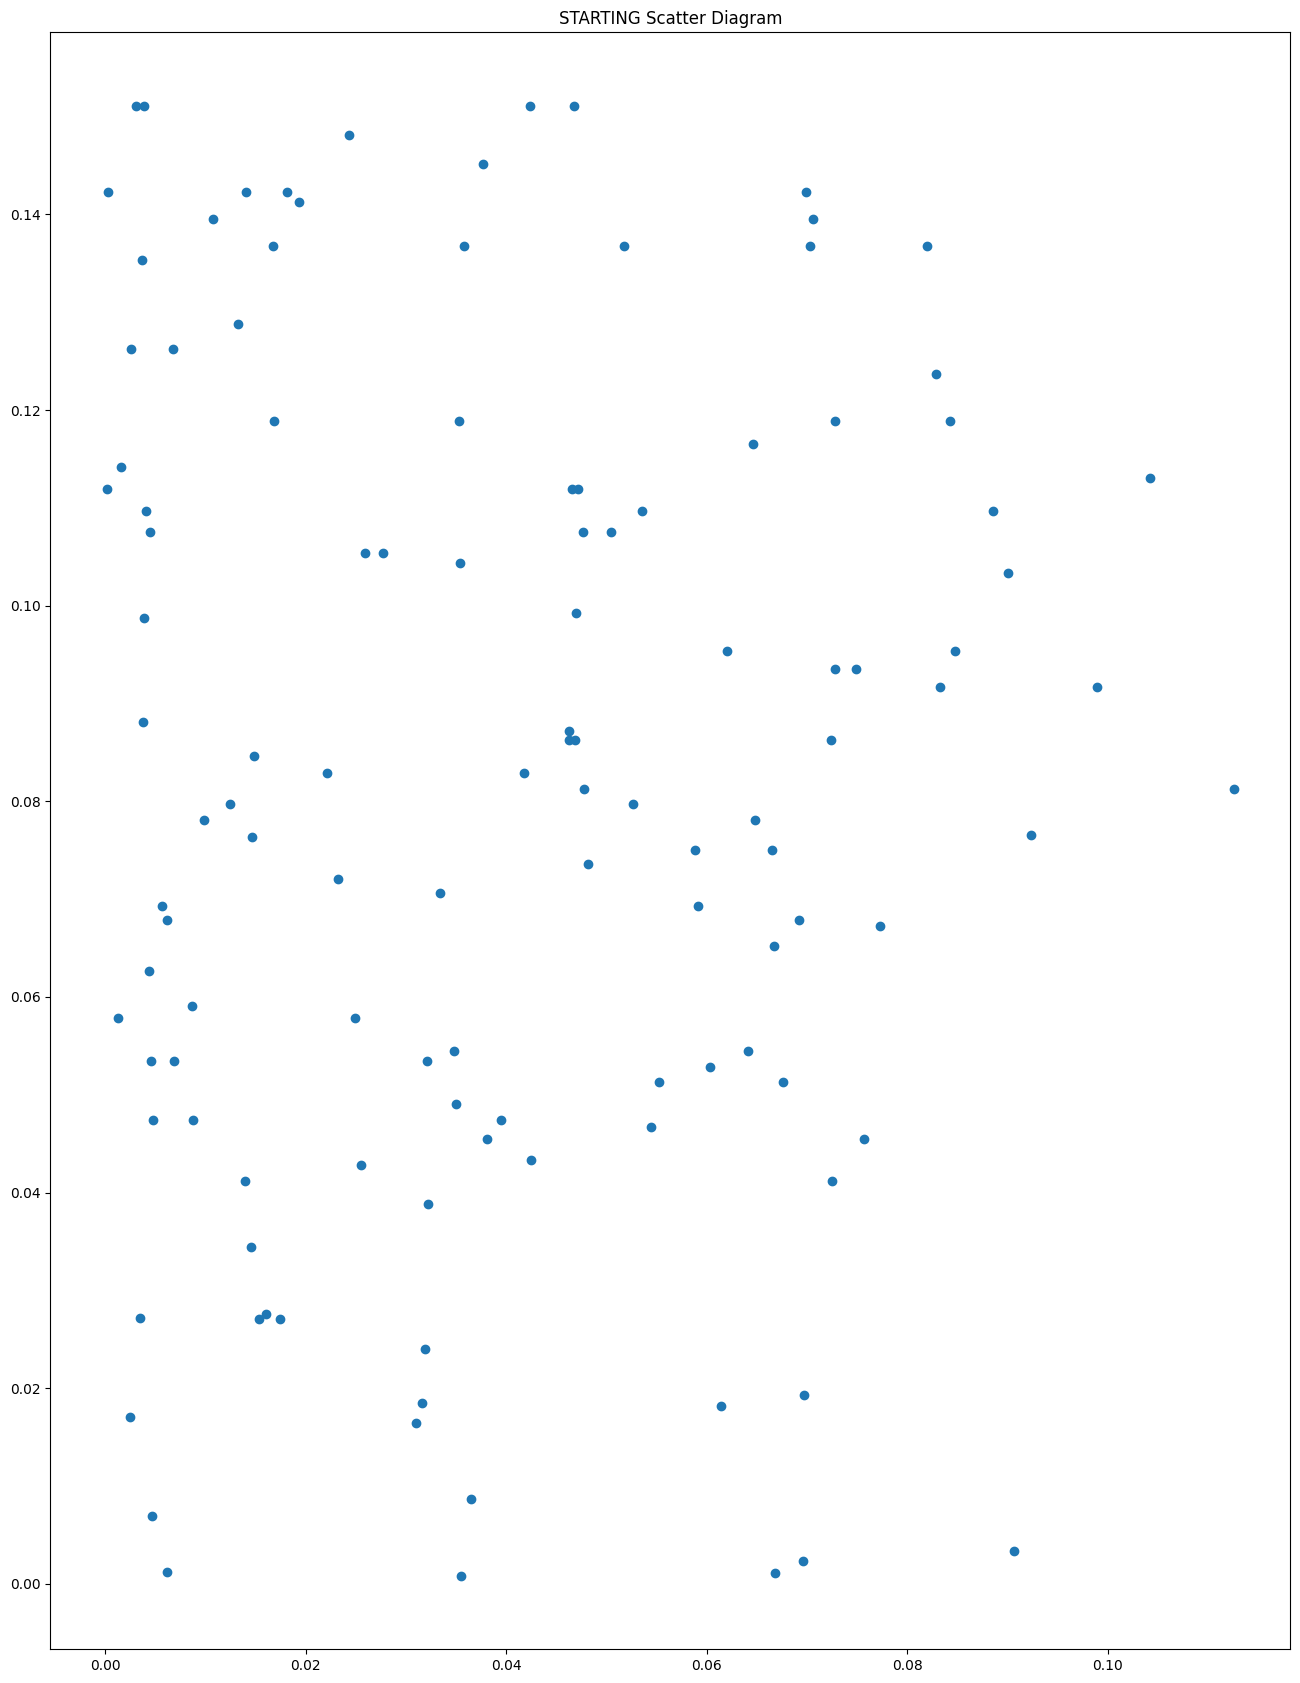

/usr/local/lib/python3.8/dist-packages/numpy/core/numeric.py:2457: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)
2022-09-01 04:24:01.031 | INFO     | src.autograd_mds:stress:53 - Sstar: 0.14827143197551682
2022-09-01 04:24:01.033 | INFO     | src.autograd_mds:stress:55 - Tstar: 1.0000000000000002
2022-09-01 04:24:01.034 | INFO     | src.autograd_mds:my_mds_training_loop:238 - stress: 0.3850602965452512
2022-09-01 04:24:01.062 | INFO     | src.autograd_mds:stress:53 - Sstar: Autograd ArrayBox with value 0.5073816225495709
2022-09-01 04:24:01.064 | INFO     | src.autograd_mds:stress:55 - Tstar: 1.0000000000000002
2022-09-01 04:24:01.101 | INFO     | src.autograd_mds:my_mds_training_loop:244 - Gradient magnitude: 0.709729883168064


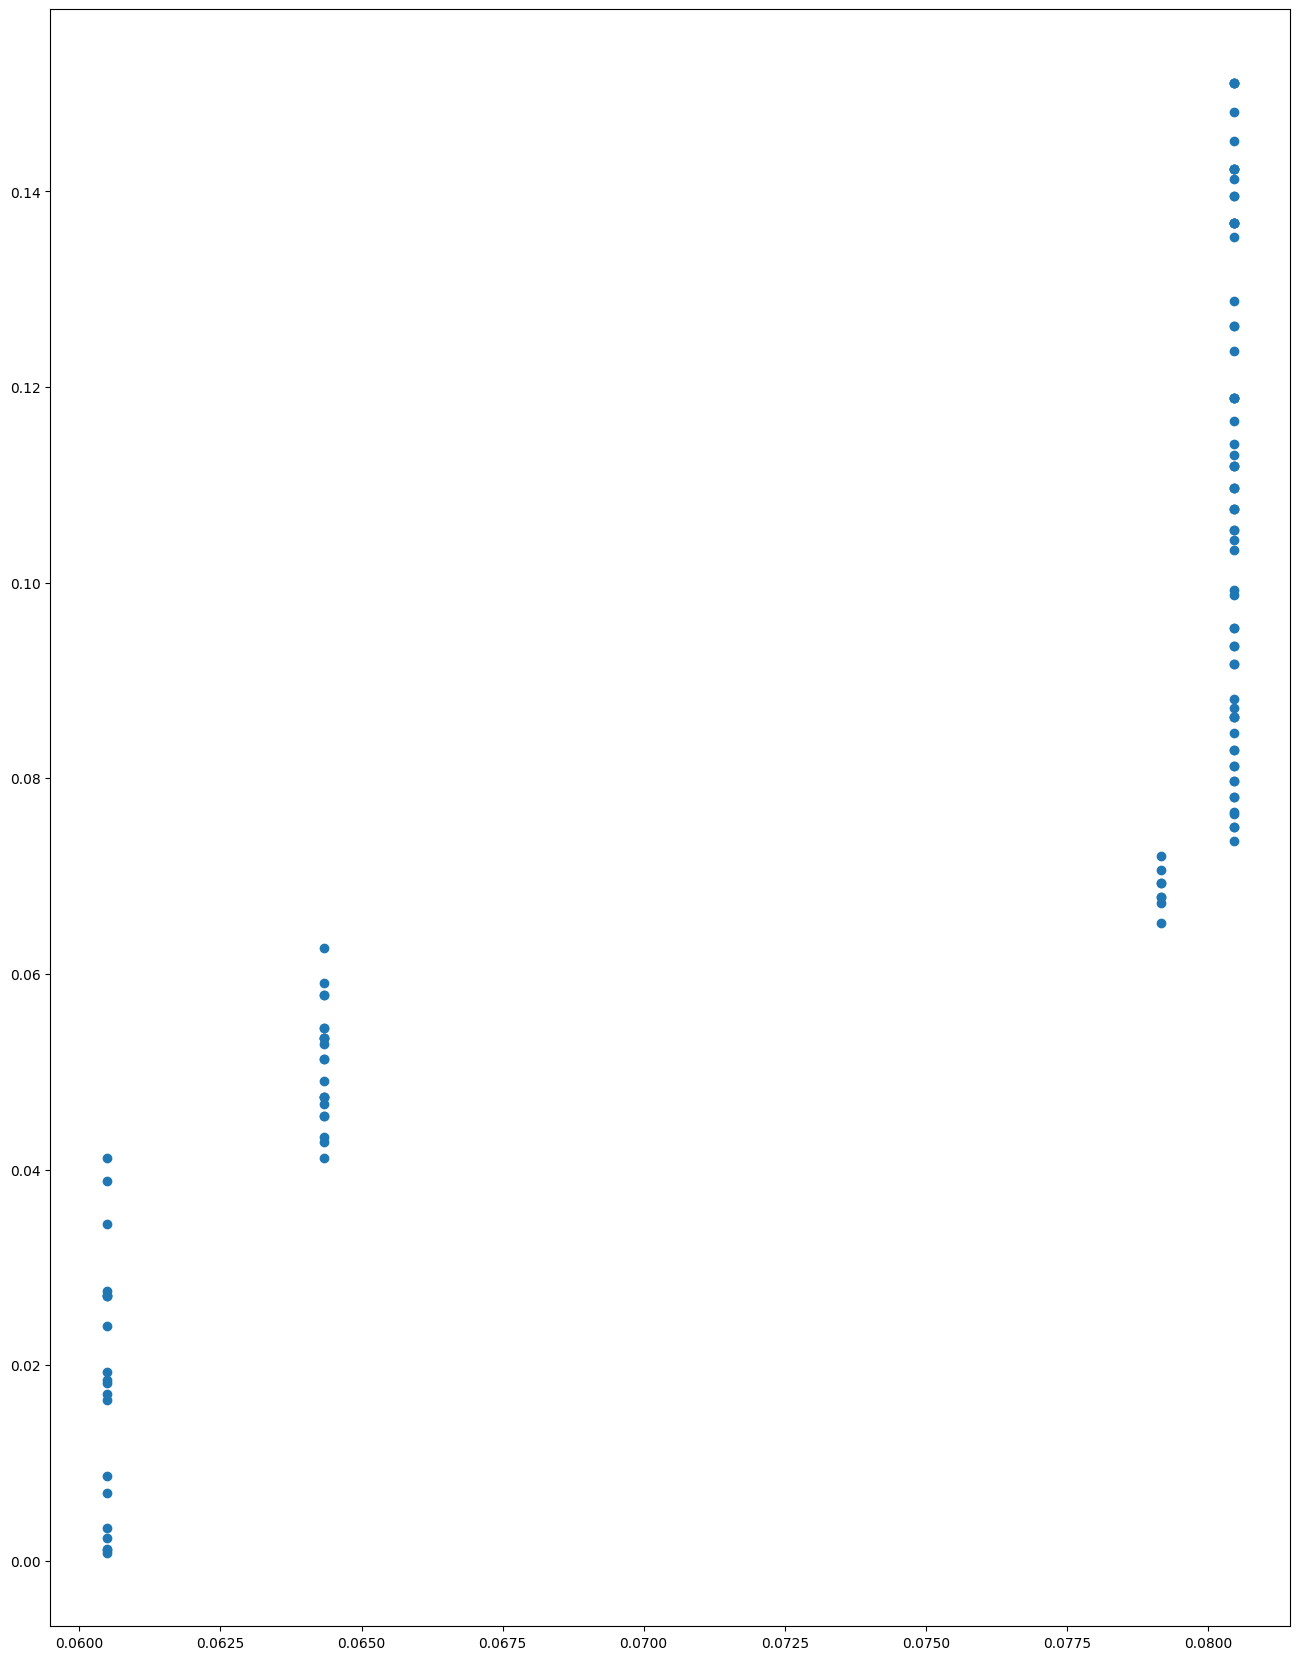

2022-09-01 04:24:01.922 | INFO     | src.autograd_mds:stress:53 - Sstar: 0.09179070349960364
2022-09-01 04:24:01.924 | INFO     | src.autograd_mds:stress:55 - Tstar: 1.0000000000000002
2022-09-01 04:24:01.925 | INFO     | src.autograd_mds:my_mds_training_loop:238 - stress: 0.30296980625072795
2022-09-01 04:24:01.958 | INFO     | src.autograd_mds:stress:53 - Sstar: Autograd ArrayBox with value 456102.4536884675
2022-09-01 04:24:01.960 | INFO     | src.autograd_mds:stress:55 - Tstar: 1.0000000000000002
2022-09-01 04:24:01.988 | INFO     | src.autograd_mds:my_mds_training_loop:244 - Gradient magnitude: 83.46593514817798


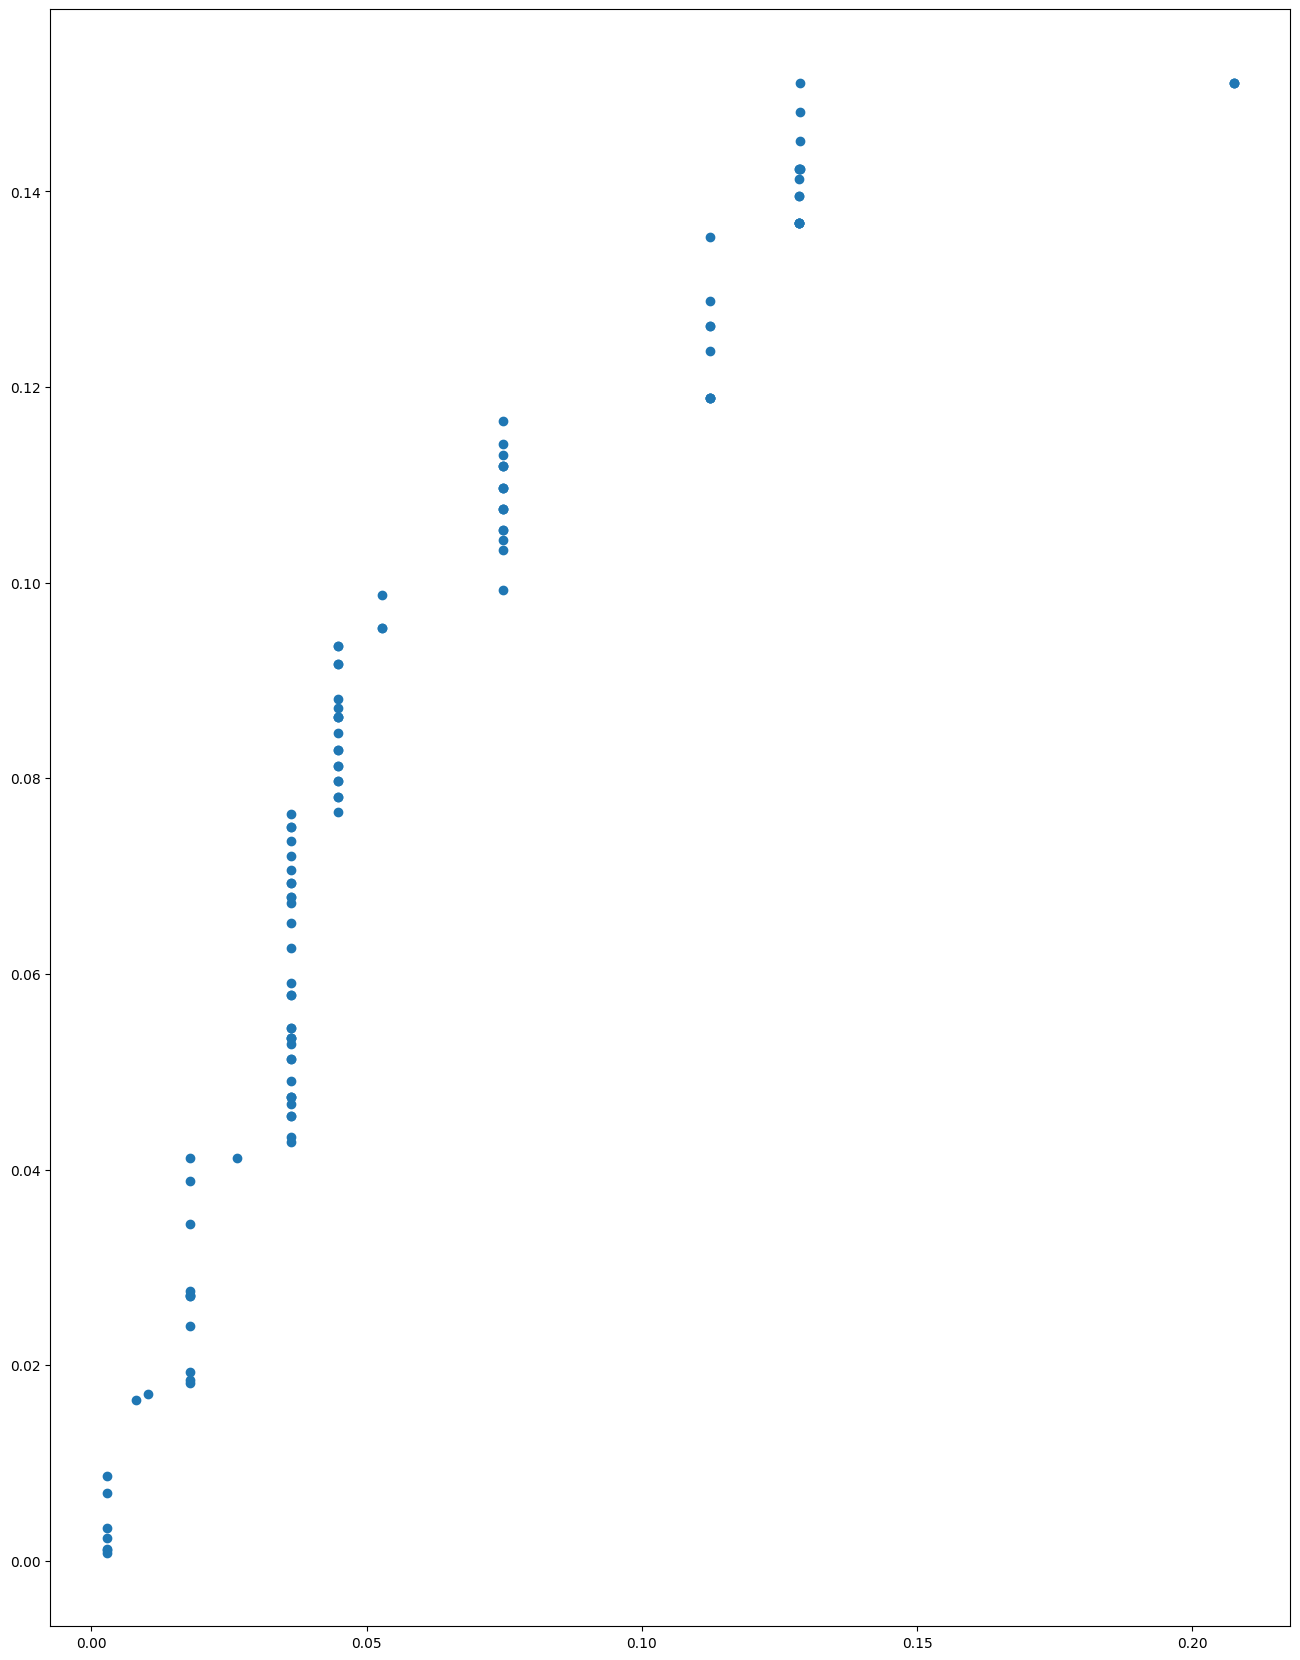

2022-09-01 04:24:02.641 | INFO     | src.autograd_mds:stress:53 - Sstar: 0.27299831204332214
2022-09-01 04:24:02.642 | INFO     | src.autograd_mds:stress:55 - Tstar: 1.0000000000000002
2022-09-01 04:24:02.648 | INFO     | src.autograd_mds:my_mds_training_loop:238 - stress: 0.5224924038139904
2022-09-01 04:24:02.677 | INFO     | src.autograd_mds:stress:53 - Sstar: Autograd ArrayBox with value 4.526073227765479e+51
2022-09-01 04:24:02.679 | INFO     | src.autograd_mds:stress:55 - Tstar: 1.0000000000000002


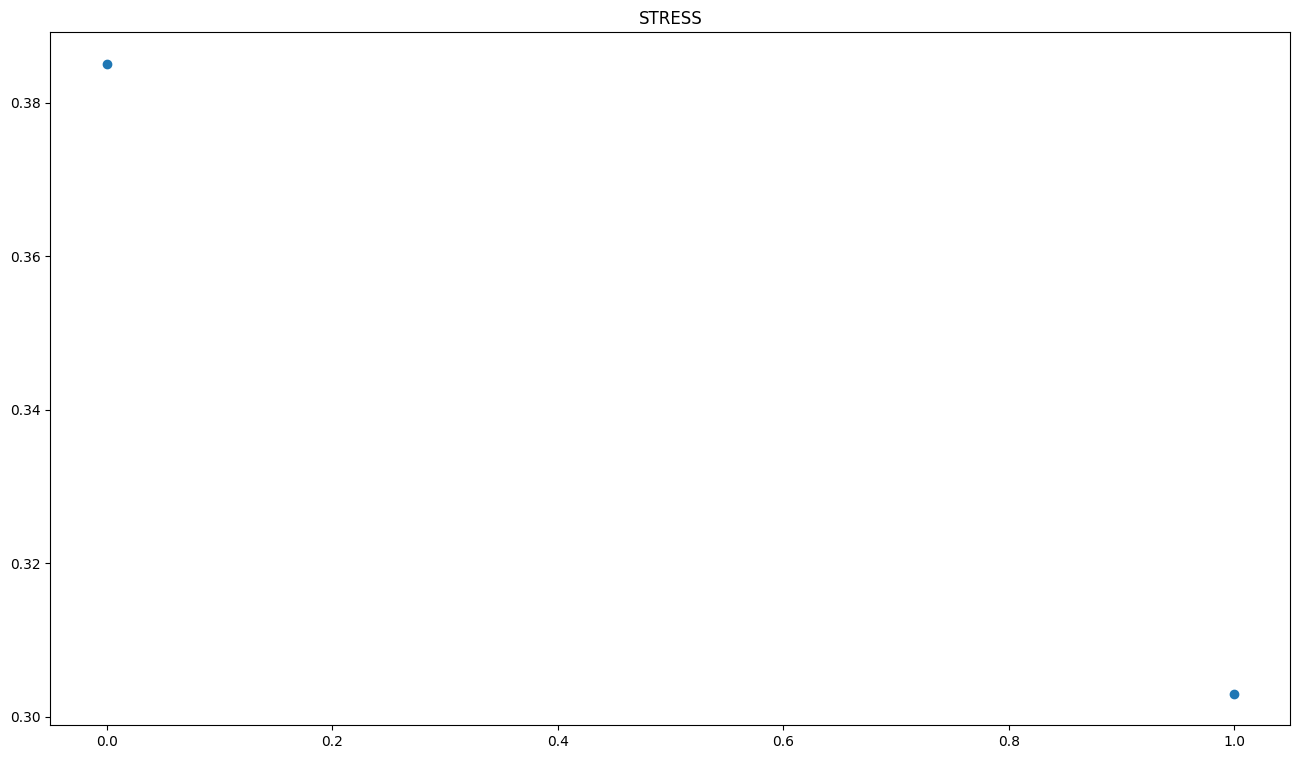

In [45]:
loop_config = my_mds_training_loop(dissimilarity_vec, n_init=1,eps =.001,dim=2)

In [46]:
## Steps 
### Define configuration 
#### for each training iteration
#### normalize 
#### find pairwise distances
#### monotone regression
#### gradient descent



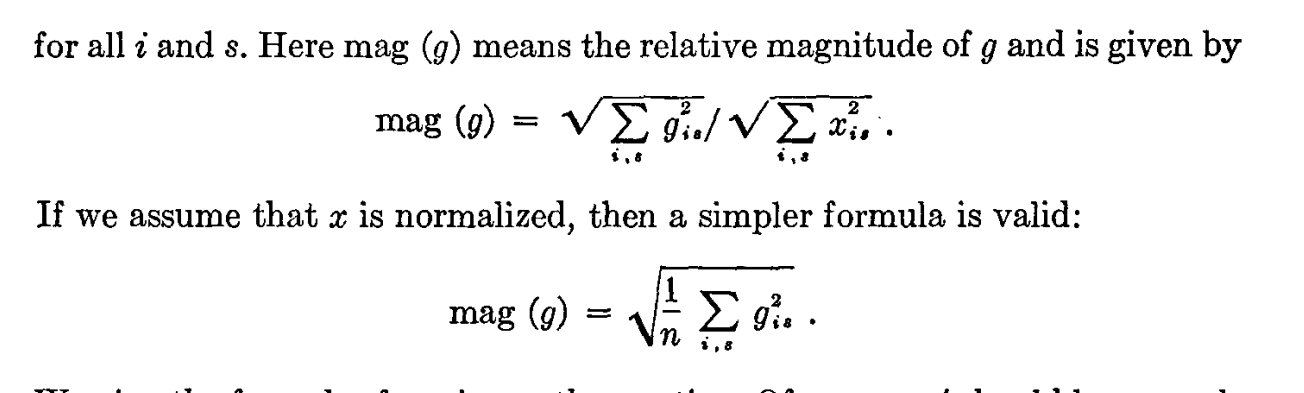

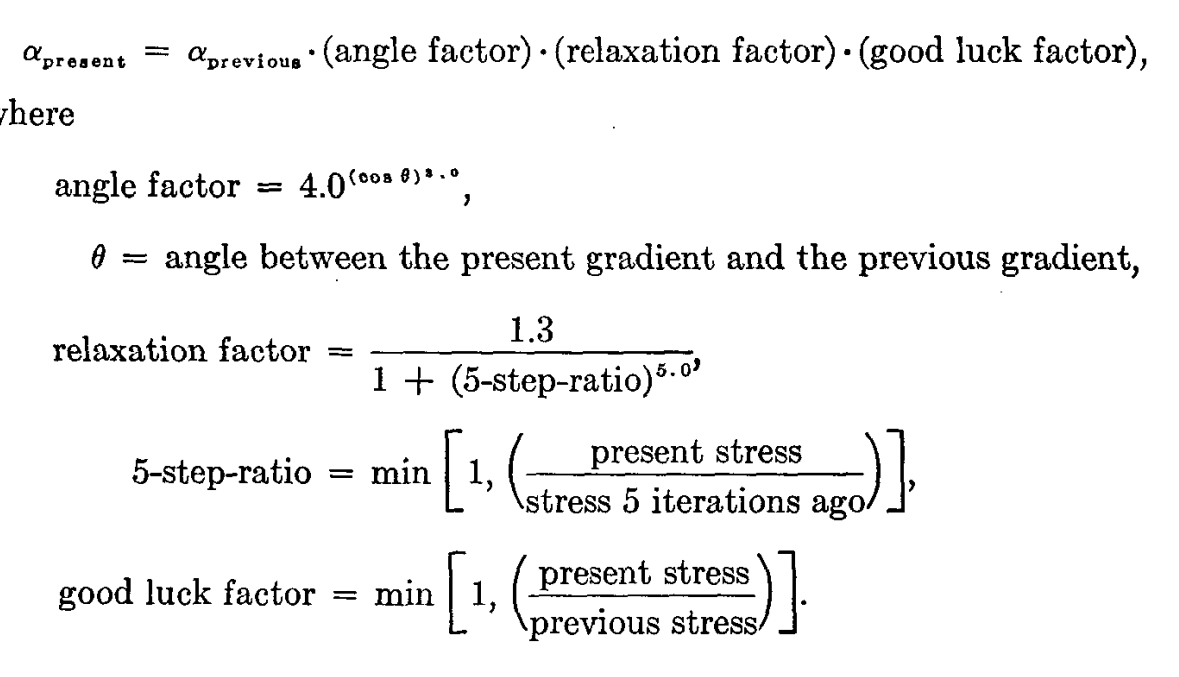

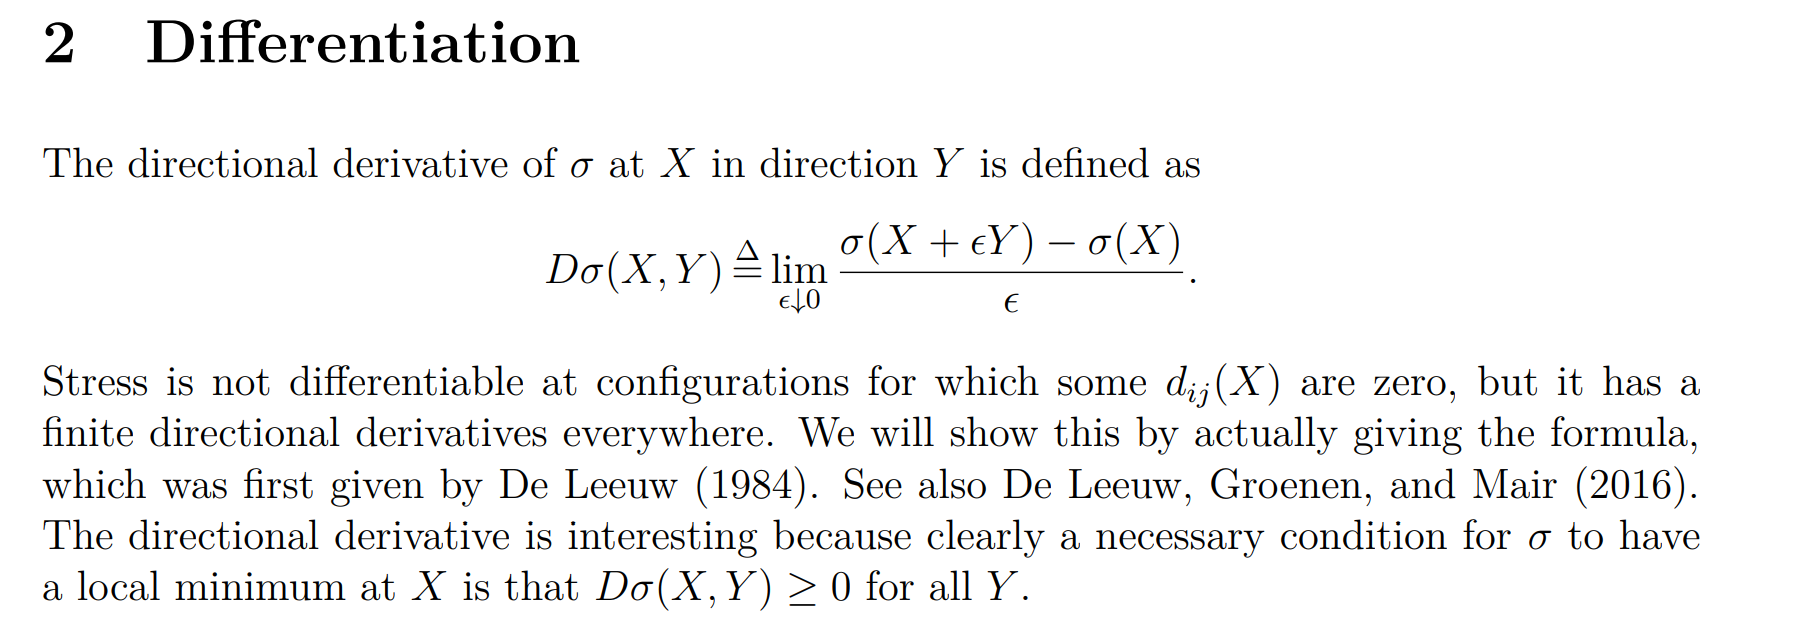
From https://jansweb.netlify.app/publication/deleeuw-e-18-c/

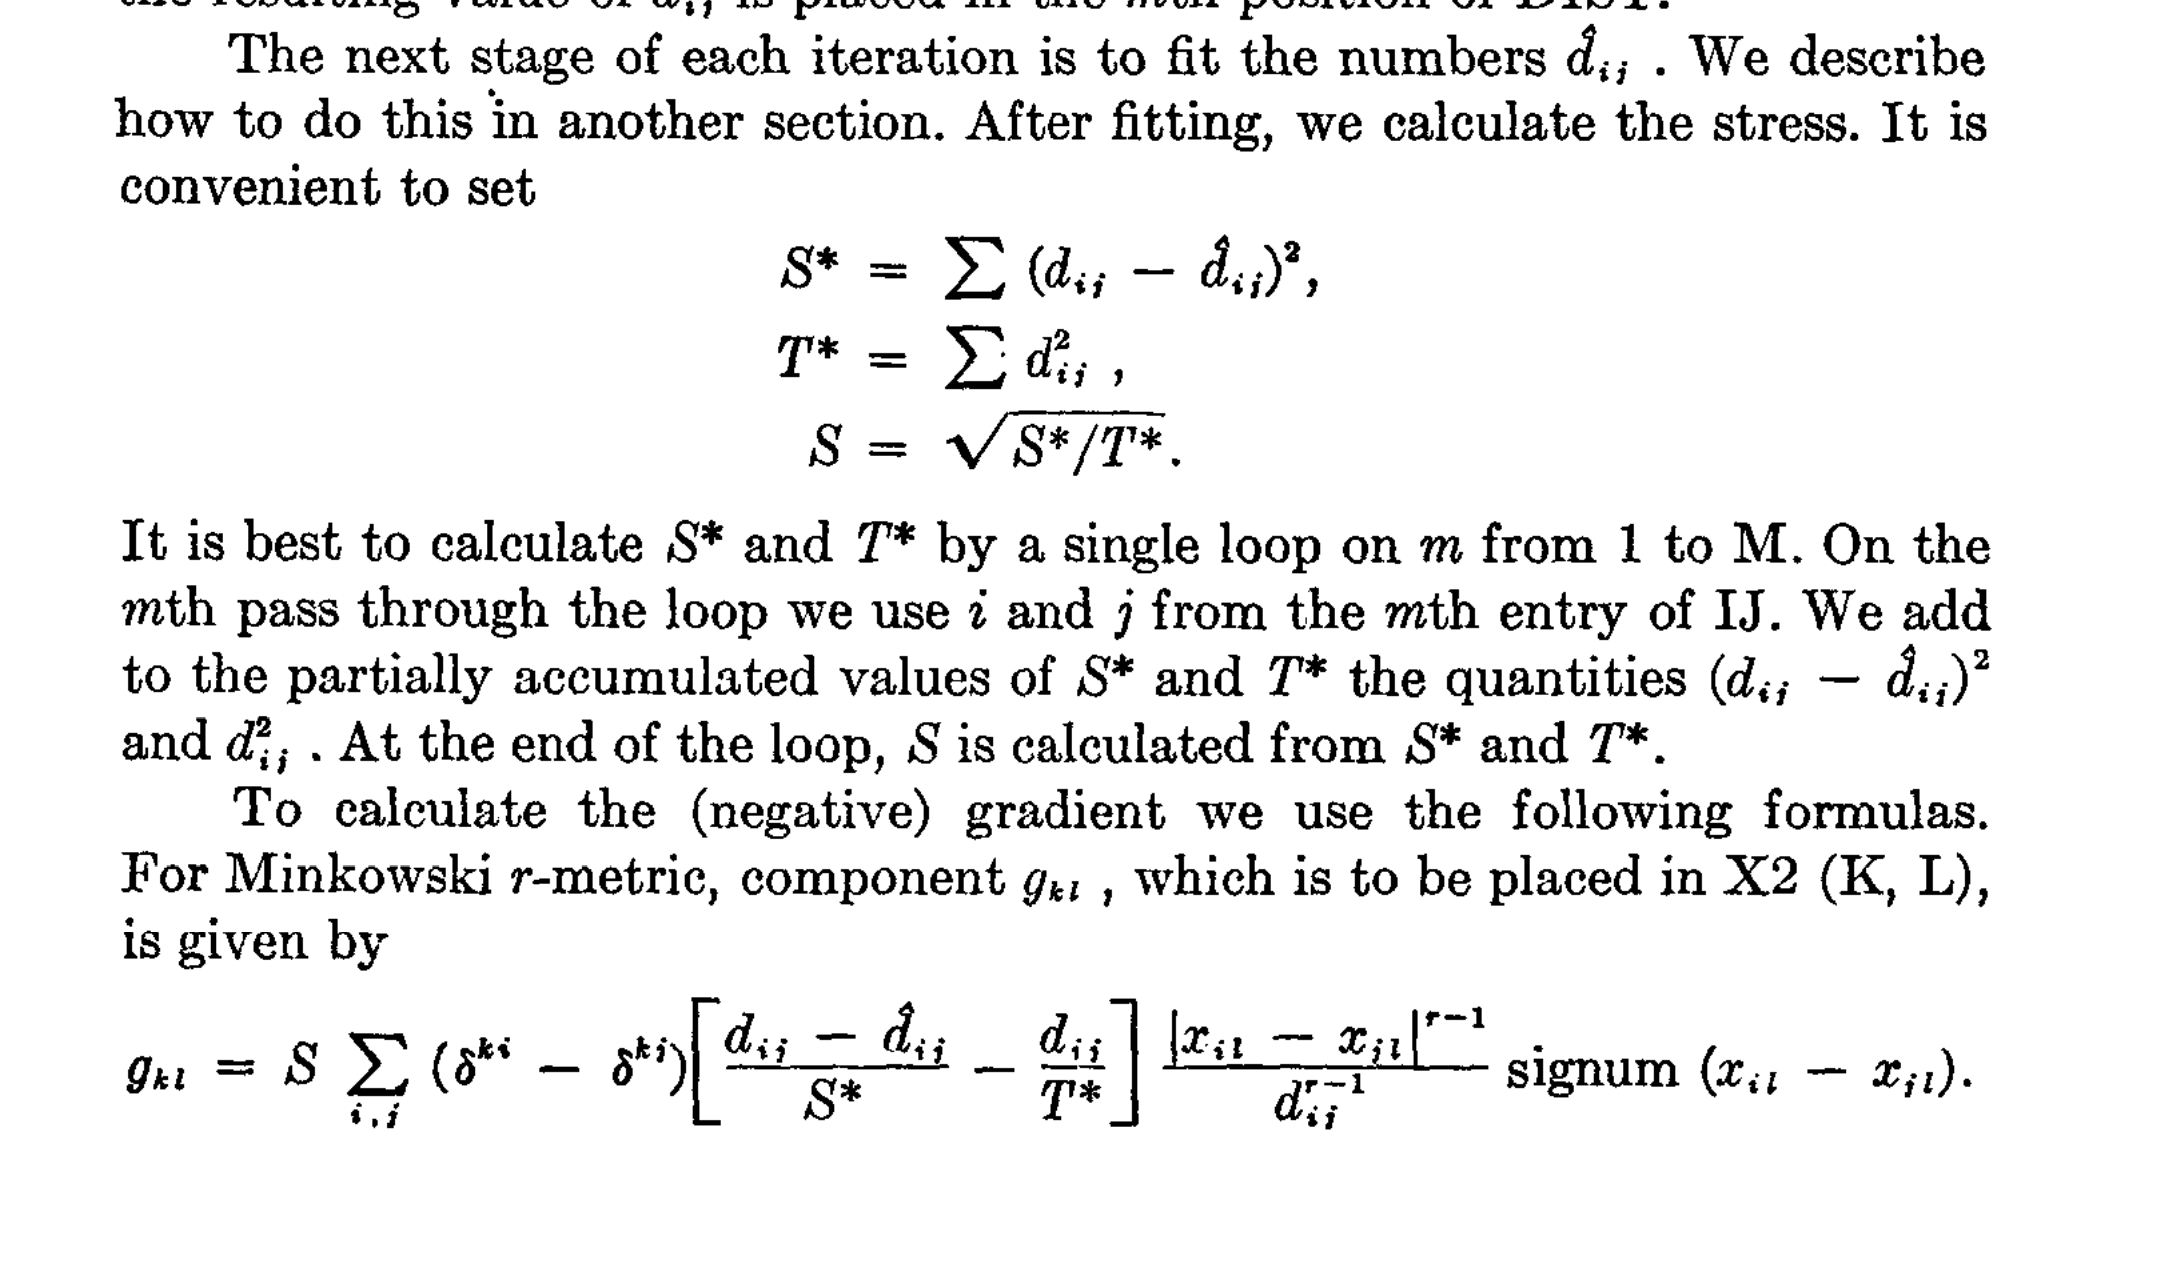
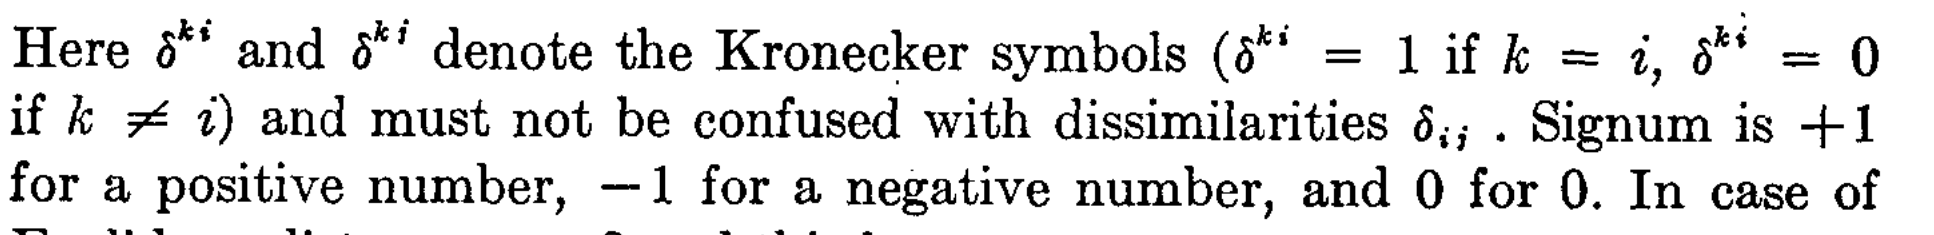
From Kruskal, 1964

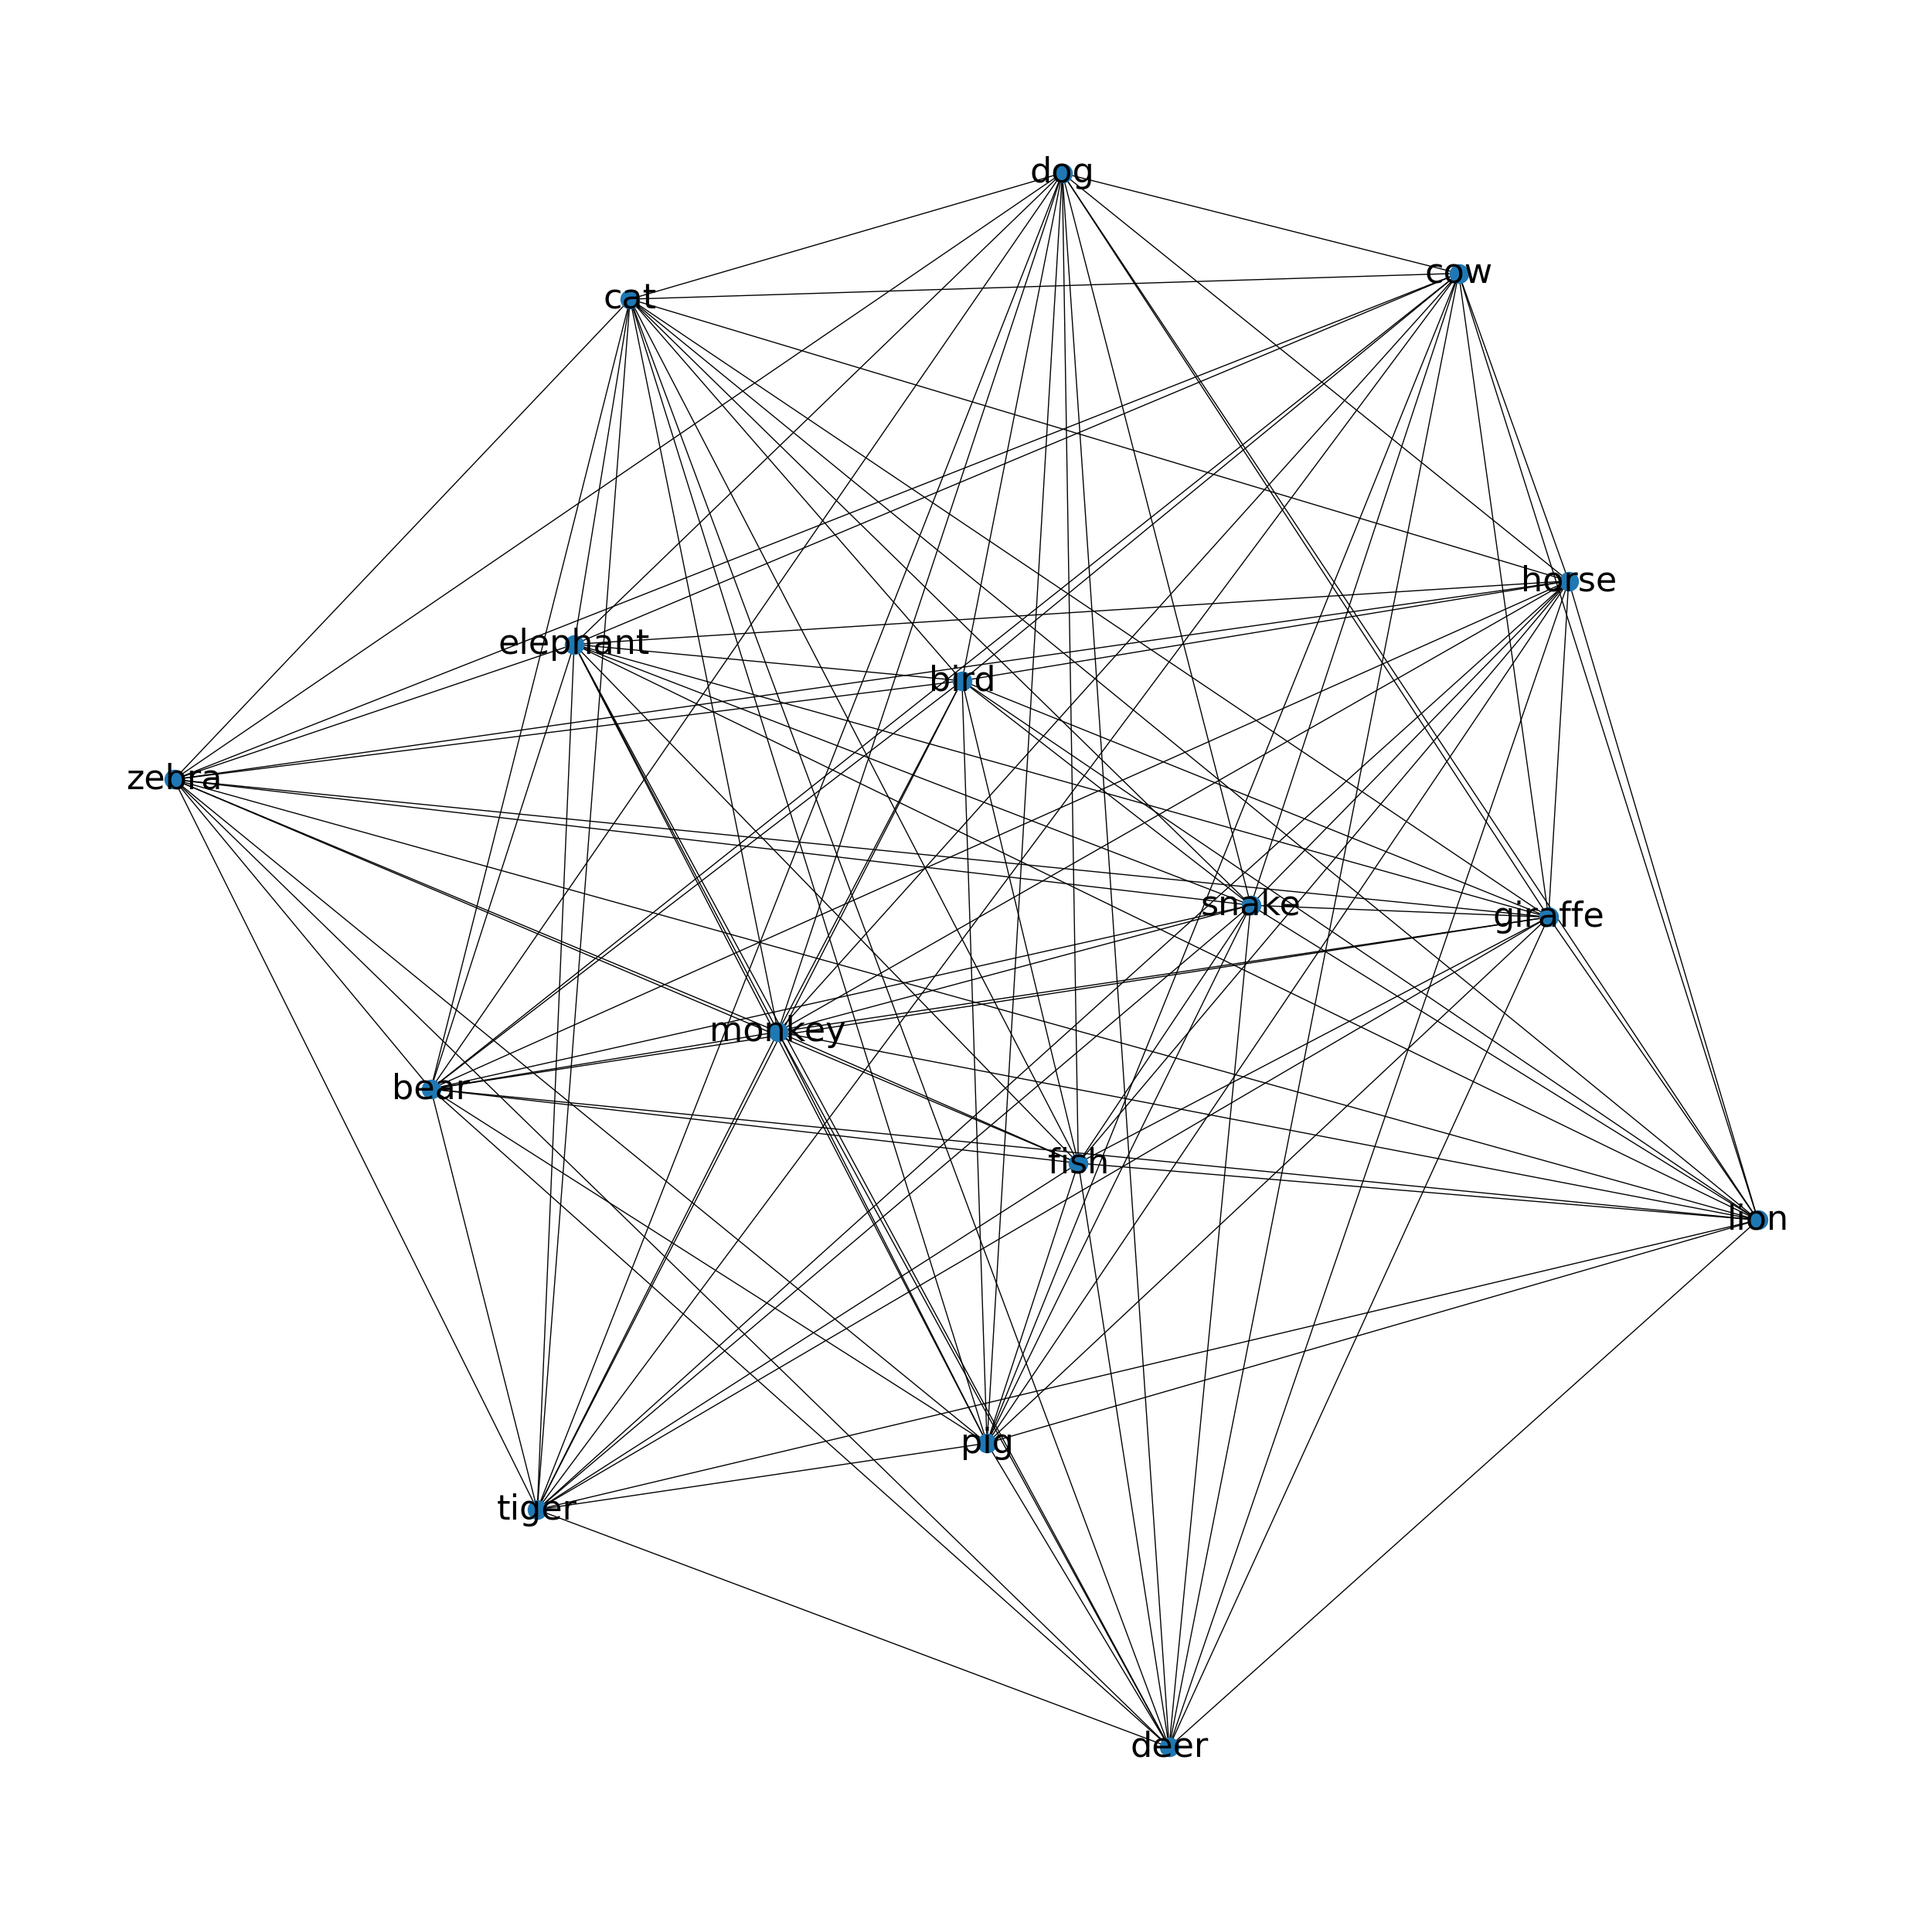

In [47]:
fig, ax = plt.subplots(figsize=(32,32))
nx.draw(animal_pairs.subgraph(big_matrix.index.to_list()), with_labels=True, ax=ax, font_size=32,
       pos=nx.spring_layout(animal_pairs.subgraph(big_matrix.index.to_list())))

plt.show()

In [48]:
refMDS = MDS(dissimilarity="precomputed",metric=False,)

In [49]:
dissimilarity_mat = np.exp(-1*np.nan_to_num(similarities)) - np.eye(similarities.shape[0])

In [50]:
plt.matshow(dissimilarity_mat)

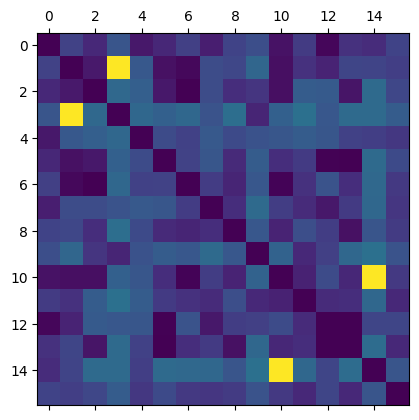

In [51]:
plt.show()

In [52]:
new_config = refMDS.fit_transform(dissimilarity_mat)

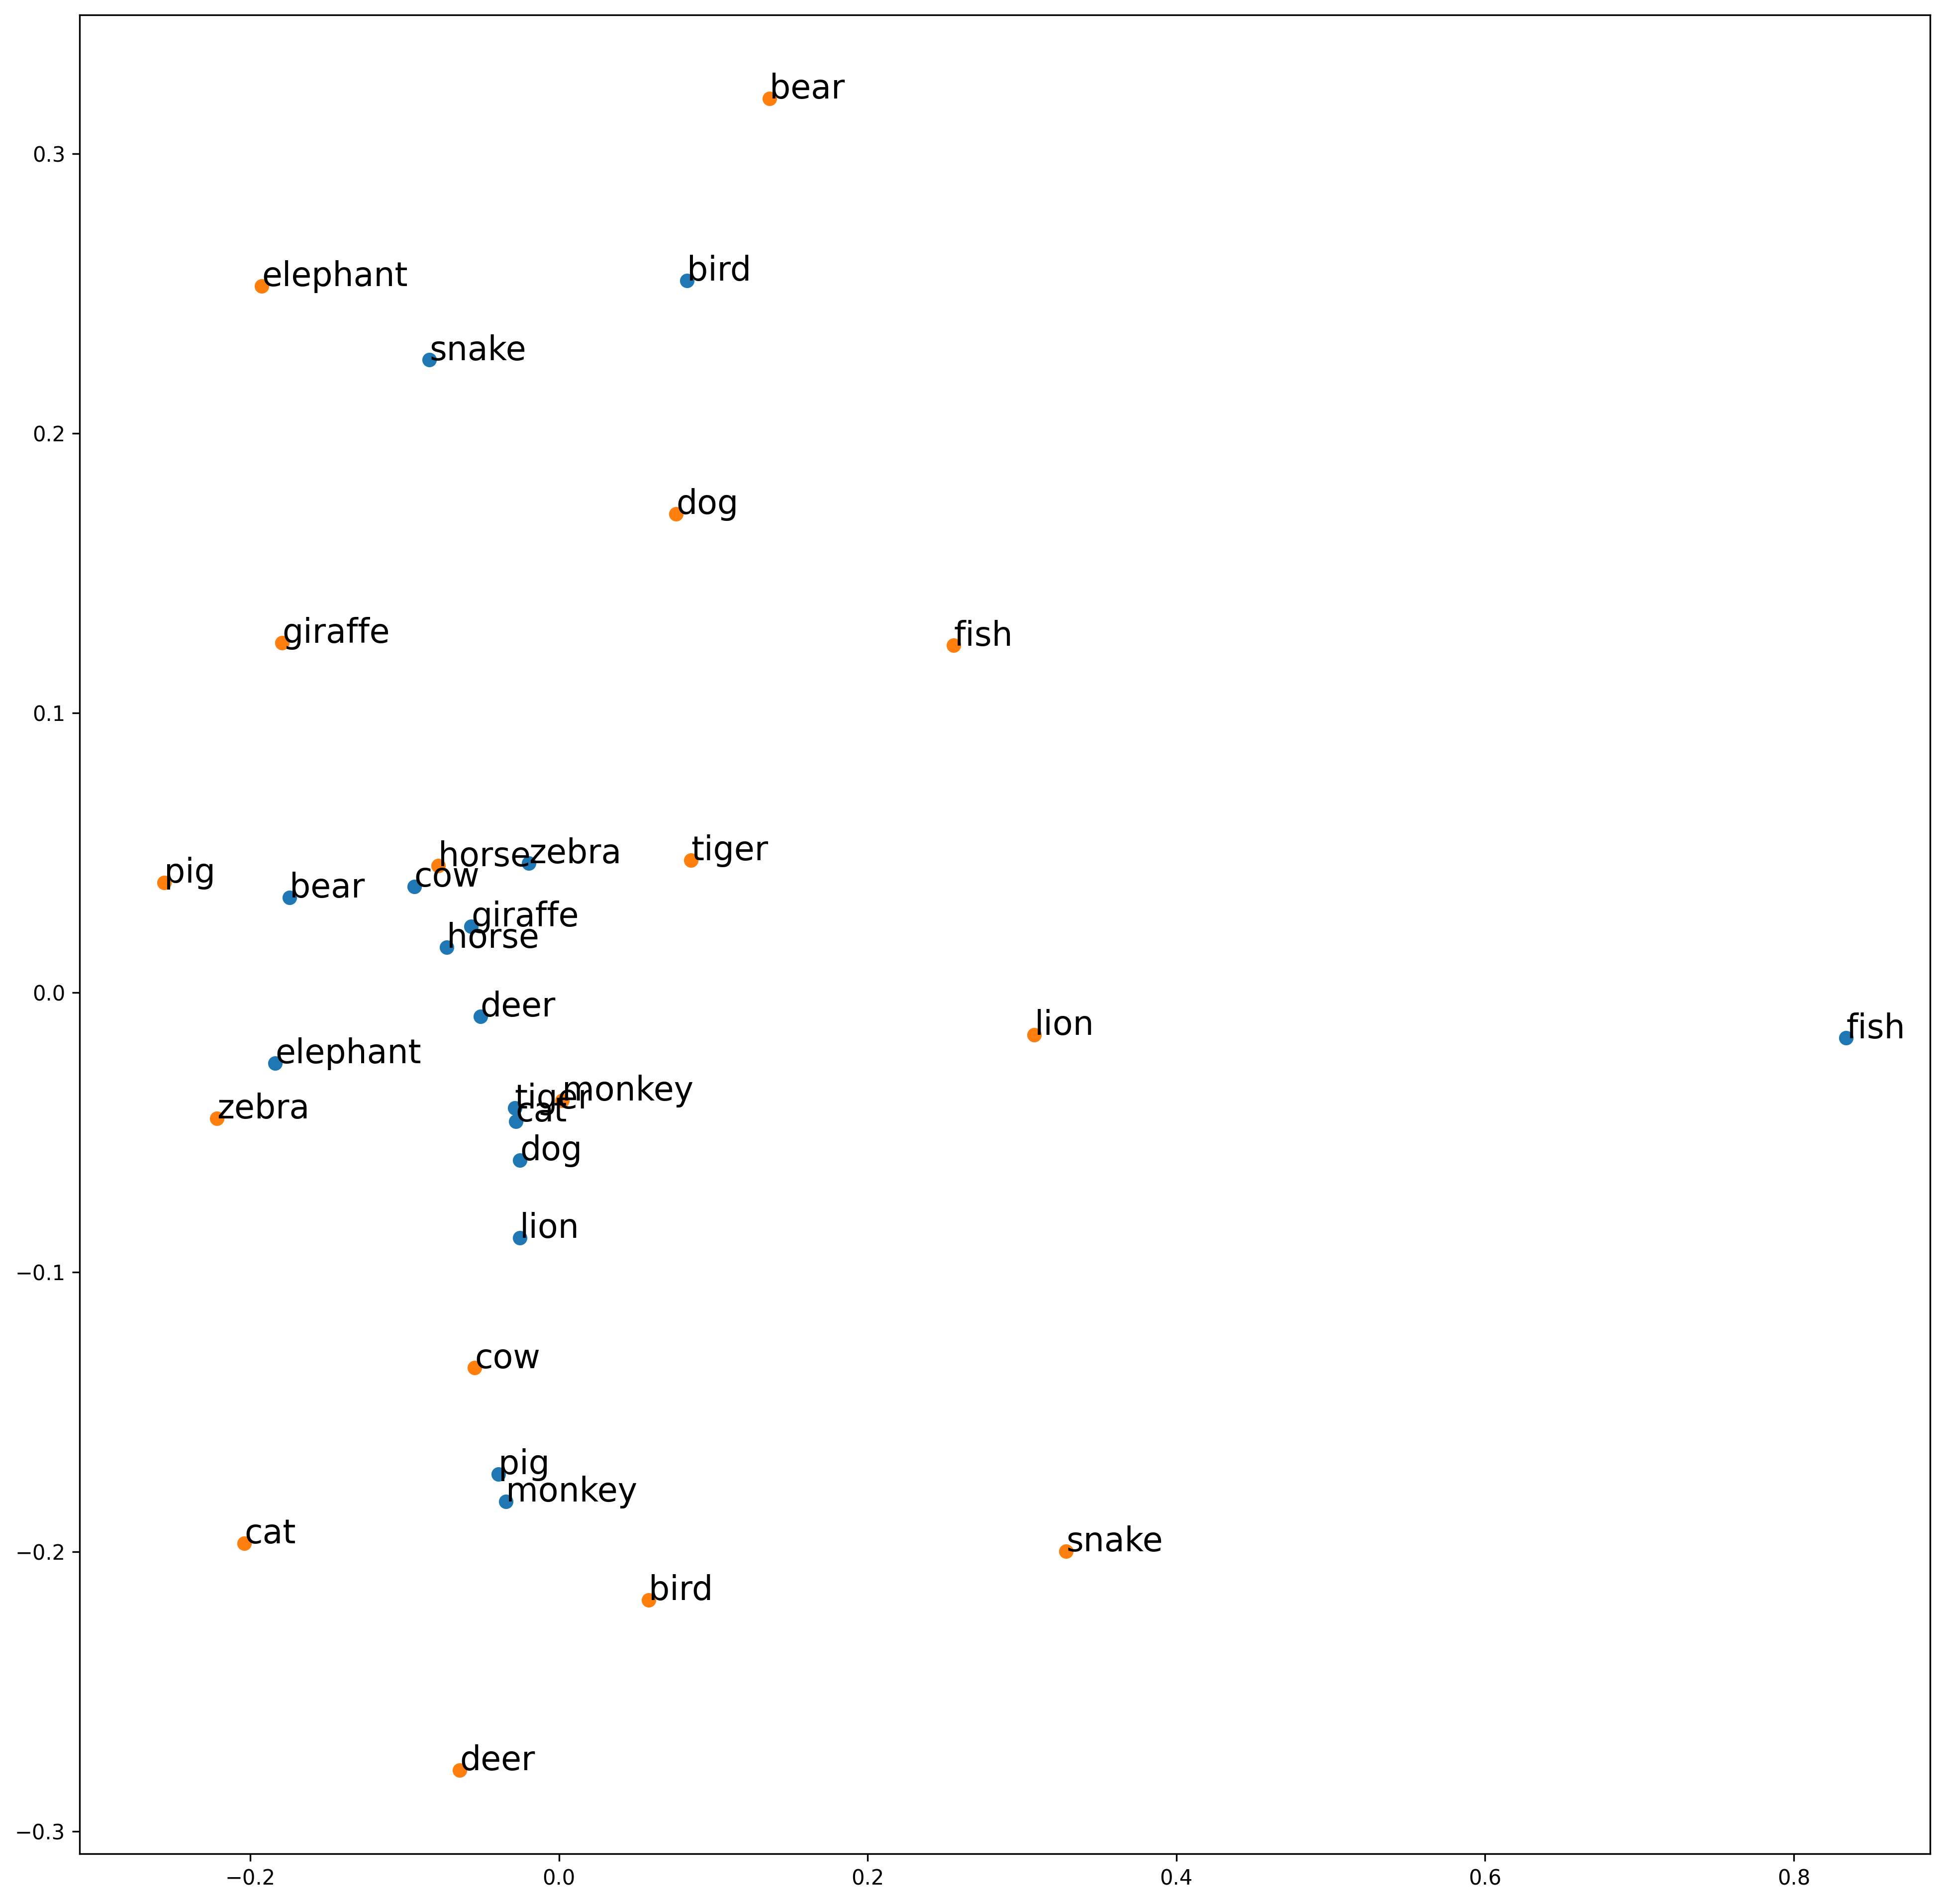

In [53]:
new_config /= np.sqrt((new_config**2).sum())
loop_config /= np.sqrt((loop_config**2).sum())
# Rotate the data
clf = PCA(n_components=2)

new_config = clf.fit_transform(new_config)
loop_config = clf.fit_transform(loop_config)

fig, ax = plt.subplots(figsize=(16,16), dpi=300)
ax.scatter(x=loop_config[:,0], y=loop_config[:,1])
for i, label in enumerate(big_matrix.index.to_list()):
       ax.annotate(label, (loop_config[i,0], loop_config[i,1]), fontsize=16)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.scatter(x=new_config[:,0], y=new_config[:,1])
for i, label in enumerate(big_matrix.index.to_list()):
       ax.annotate(label, (new_config[i,0], new_config[i,1]), fontsize=16)

# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

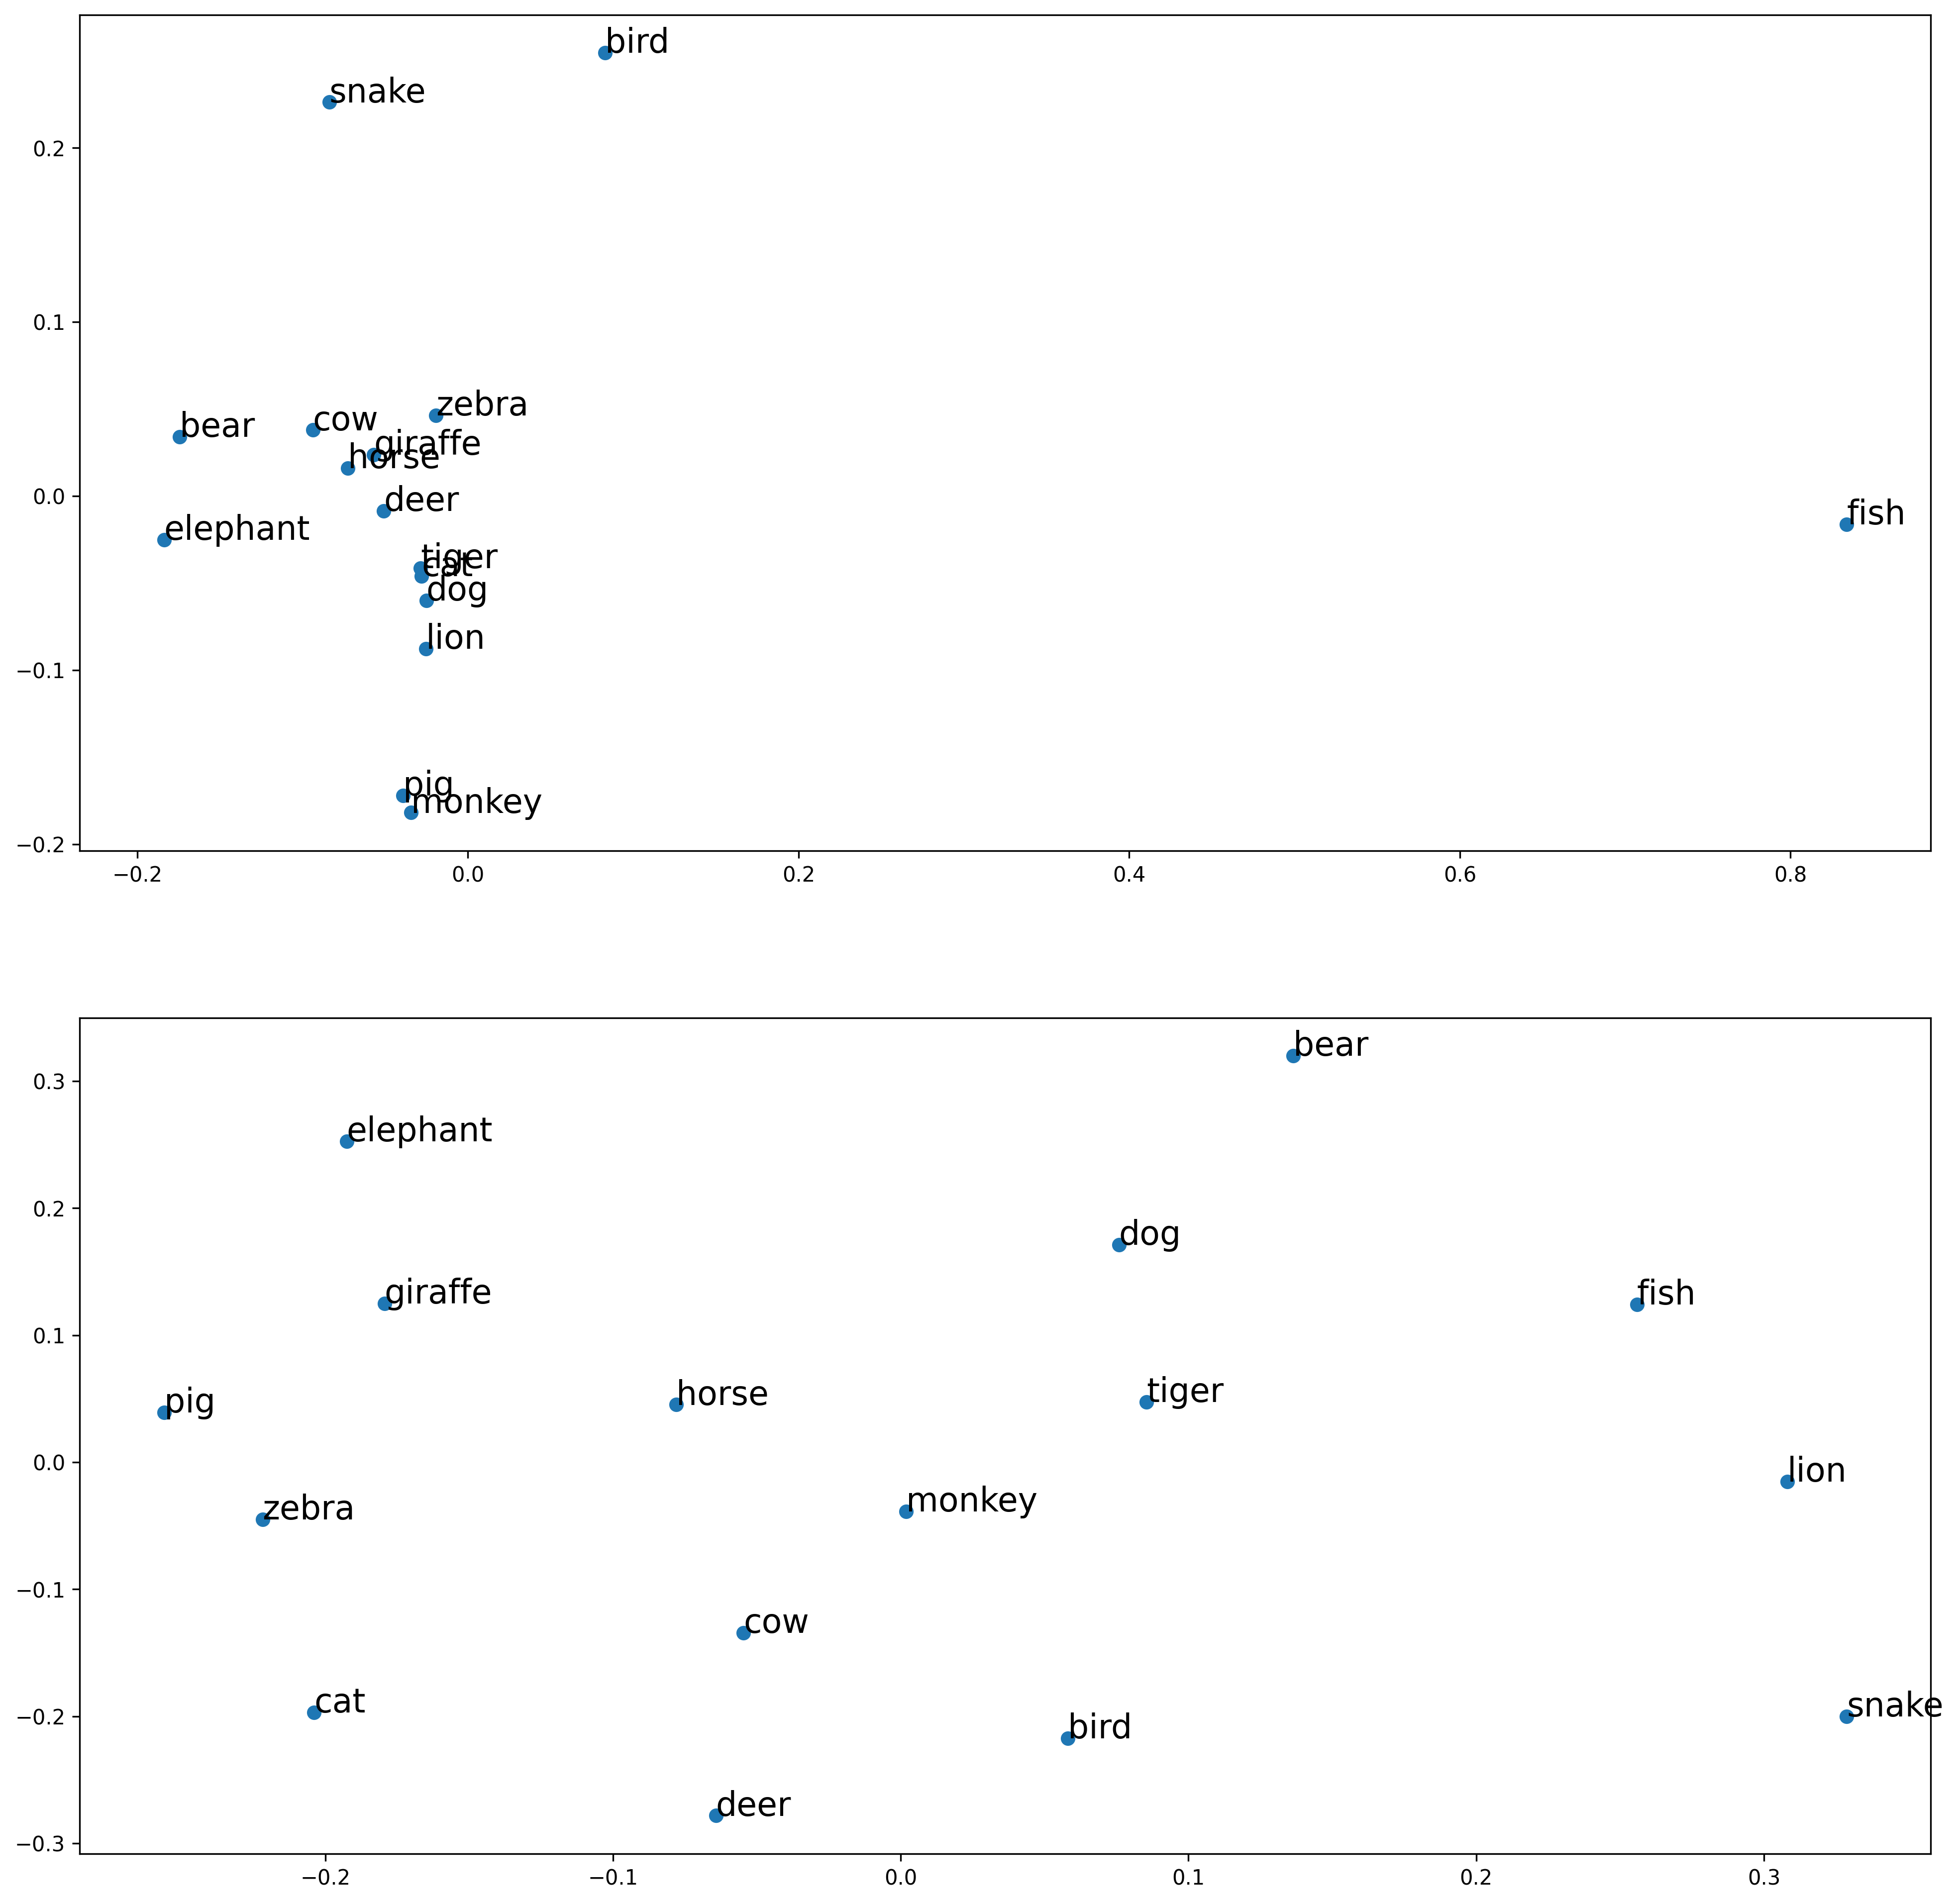

In [54]:
new_config /= np.sqrt((new_config**2).sum())
loop_config /= np.sqrt((loop_config**2).sum())
# Rotate the data
clf = PCA(n_components=2)

new_config = clf.fit_transform(new_config)
loop_config = clf.fit_transform(loop_config)

fig, ax = plt.subplots(2,1,figsize=(16,16), dpi=300)
ax[0].scatter(x=loop_config[:,0], y=loop_config[:,1])
for i, label in enumerate(big_matrix.index.to_list()):
       ax[0].annotate(label, (loop_config[i,0], loop_config[i,1]), fontsize=16)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax[1].scatter(x=new_config[:,0], y=new_config[:,1])
for i, label in enumerate(big_matrix.index.to_list()):
       ax[1].annotate(label, (new_config[i,0], new_config[i,1]), fontsize=16)

# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

In [55]:
# test successive approximation
import pytest
import numpy as np
from numpy.testing import assert_approx_equal
from autograd import elementwise_grad
from src.autograd_mds import get_pairwise_distances
## 

@pytest.fixture
def three_four_five_2d():
    three_four_five = np.array([[0.,0.], [0.,4.,], [3.,4.]])
    return three_four_five

def test_dist_deriv_345(triangle):
    """
    From Guttman:
    d(dist)/d(x_ha) = 2 *yija * (xia-xja) *(delta_hi - delta_hj)\
    = 2*abs((xia-xja))**0/(2*dij)*(xia-xja) *(delta_hi - delta_hj)
    =(xia-xja) *(delta_hi - delta_hj)/(dij))
    """
    gradient = elementwise_grad(get_pairwise_distances)
    ## gradient should be a n(n-1)/2 x (n_obs x n_dim) tensor
    assert_approx_equal(gradient(triangle), )
    pass

In [60]:
tff=  np.array([[0.,0.], [0.,4.,], [3.,4.]])

In [88]:
def ugly_jacobian(arr, pwds):
    ## keep track of difference indices 
    ijs = list(zip(np.triu_indices(arr.shape[0],k=1)[0], np.triu_indices(arr.shape[0],k=1)[1]))
    
    ## tensor out
    out_array = np.zeros(len(pwds), *arr.shape)
    
    #
    for h in range(arr.shape[0]):
        for a in range(arr.shape[1]):
            ## flip sign for other
            ## how to apply kronecker delta here?
            distance_counter += 1
    return out_array

In [65]:
eg = jacobian(get_pairwise_distances)

In [66]:
get_pairwise_distances(tff)

array([16., 25.,  9.])

[(0, 1), (0, 2), (1, 2)]